# Métricas para evaluar el resultado de los VS
## Análisis de datos exploratorio

- 111 ligandos
    - 27 Activos
- 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales
- 3 progrmas de acoplamiento molecular

### Contenido:
- Pendiente agregar las secciones

In [2]:
import pandas as pd 
import numpy as np 

### Carga de los datos

In [3]:
data_dir = '../data'
# Carga de los dataFrames
# Autodock 4. LE (lowest energy), LC (largest Cluster)
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)

Todos los dataFrames poseen 111 filas (111 ligandos) y 403 columnas, correspondientes a la etiqueta de actividad/inactividad, y a las 402 conformaciones. 

# Datos CDK2 de CSAR
Las etiquetas de actividad y la información sobre los 111 ligandos se encuentran en el siguiente [enlace](https://drugdesigndata.org/about/datasets/220).

### Valores verdaderos de los ligandos

Definimos la variable `true_values`, un arreglo que contiene la información sobre los 111 ligandos. Cada posición representa un ligando con valores de 0 o 1, donde **1 = Activo**, indica que el ligando es una molécula capaz de unirse experimentalmente a la proteína. Los ligandos están ordenados alfanuméricamente.

In [4]:
df_vina_results[['ActiveInactive']].T

Ligando            CS1     CS2     CS3     CS4       CS5     CS9    CS10  \
ActiveInactive  Active  Active  Active  Active  Inactive  Active  Active   

Ligando           CS11    CS12    CS13  ...   CS241   CS242   CS244   CS245  \
ActiveInactive  Active  Active  Active  ...  Active  Active  Active  Active   

Ligando          CS246   CS247   CS248   CS260   CS261   CS262  
ActiveInactive  Active  Active  Active  Active  Active  Active  

[1 rows x 111 columns]

Como se observa en la tabla superior, las moléculas activas corresponden a los primeros (excepto CS5) y los últimas moléculas de la tabla.

In [5]:
# Etiquetas de las moléculas (1 = activo)
true_values = np.array(df_vina_results.ActiveInactive == "Active", dtype=int)
print(true_values)

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


Para facilitar el análisis inicial, evaluaremos cada una de las siguientes métricas utilizando únicamente el scoring de una conformación de la proteína CDK2; la conformación *2vv9*. Más adelante se calcularán las métricas para todas.

#### Scores de los 4 métodos de docking evaluados (AD4, Vina y Vinardo)

In [6]:
# Estos scores son para ejemplificar la ejecución de las métricas
pdb_id = '2vv9'
y_score_vrd = np.array(df_vinardo_results[pdb_id])
y_score_vina = np.array(df_vina_results[pdb_id])
y_score_ad4_LE = np.array(df_ad4_results_LE[pdb_id])
y_score_ad4_LC = np.array(df_ad4_results_LC[pdb_id])

#### Clasificador Aleatorio
Adicionalmente, creamos un conjunto de valores obtenidos de forma aleatoria con `numpy`, simulando el resultado de un *dummy classifier*.

In [7]:
y_score_RANDOM = np.random.uniform(-10, 0, len(true_values))

#### Clasificador ideal

In [8]:
y_score_PERFECT = np.array([-10 if i else -5 for i in true_values])

In [9]:
dic_scores = {"AD4 LE": y_score_ad4_LE, "AD4 LC": y_score_ad4_LC, 
               "Vina": y_score_vina, "Vinardo": y_score_vrd,
               "Random Clf": y_score_RANDOM, "Perfect Clf": y_score_PERFECT}

### Visualización de la distribución de activos/inactivos en el *ranking*
A continuación se muestra el *ranking* obtenido con cada una de las herramientas de *docking* en el que se destacan en color rojo los ligandos activos.

In [323]:

class PlotMetric:
    def __init__(self, y_true, y_pred_dict, decreasing = False, color_palette = 'Paired'):
        if type(y_true) is not np.ndarray:
            raise('y_true should be a numpy array with values 1 = active and 0 = inactive')
        self.y_true = y_true

        if type(y_pred_dict) is not dict or len(y_pred_dict) < 1:
             raise('y_pred_dict should be a dictionary with key = "Cfl name" and value = np.array with predicted values')
        self.y_pred_dict = y_pred_dict
        if decreasing:
            for key, y_pred in y_pred_dict.items():
                y_pred_dict[key] = -1 * y_pred

        self.color_palette = color_palette
    
    # ROC
    def _get_roc(self, y_pred):
        fpr, tpr, thresholds = roc_curve(y_true = self.y_true, y_score = y_pred)
        return fpr, tpr, thresholds
    # ROC-AUC
    def _get_roc_auc(self, y_pred):
        return(roc_auc_score(y_true = self.y_true, y_score = y_pred))

    def _add_plot_roc(self, y_pred, label, **kwargs):
        print(kwargs.items())
        fpr, tpr, thresholds = self._get_roc(y_pred)
        auc = self._get_roc_auc(y_pred)
        plt.plot(fpr, tpr, label = label + ' AUC = %0.2f' % auc, **kwargs)
        

    def plot_roc_auc(self, title, keys_to_omit = [], fontsize='small', lw = 3, linestyle = '-'):
        sns.color_palette(self.color_palette)
        for key, y_pred in self.y_pred_dict.items():
            if key in keys_to_omit:
                continue
            self._add_plot_roc(y_pred, label = key, lw = lw, linestyle = '-')
        plt.legend(fontsize=fontsize)
        plt.plot([0, 1], [0, 1], 'k--', c = 'gray')
        plt.xlabel("FPR (1 - specificity)")
        plt.ylabel("TPR (sensitivity)")
        plt.grid(linestyle='--', linewidth='0.8')
        plt.title(title)
        plt.show()

dict_items([('lw', 3), ('linestyle', '-')])
dict_items([('lw', 3), ('linestyle', '-')])
dict_items([('lw', 3), ('linestyle', '-')])
dict_items([('lw', 3), ('linestyle', '-')])
dict_items([('lw', 3), ('linestyle', '-')])


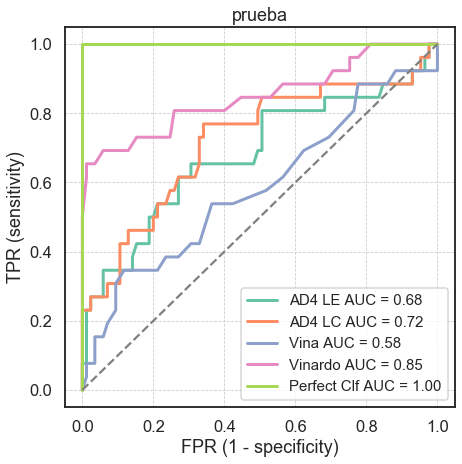

In [327]:
c = PlotMetric(y_true= true_values, y_pred_dict=dic_scores)
c.plot_roc_auc('prueba', keys_to_omit=['Random Clf'])

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotActivesDistribution(y_true, y_pred, name = '', skip_order = False):
    colors = {1: '#e74c3c', 0: '#FCD988'}
    if not skip_order:
        order = np.argsort(y_pred)
        y_pred_ord = y_pred[order]
        y_true = y_true[order]
    colors_array = [colors[i] for i in y_true]
    sns.palplot(sns.color_palette(colors_array))
    plt.title('\n' + name + '\n', fontsize=100)
    return

def format_metric(metric, metric_name, y_true, dic_y_preds):
    dic_metrics = {}
    for key, y_pred in dic_y_preds.items():
        dic_metrics[key] = metric(y_true, y_pred)
    df = pd.DataFrame(dic_metrics, index = [metric_name])
    return df.round(3)

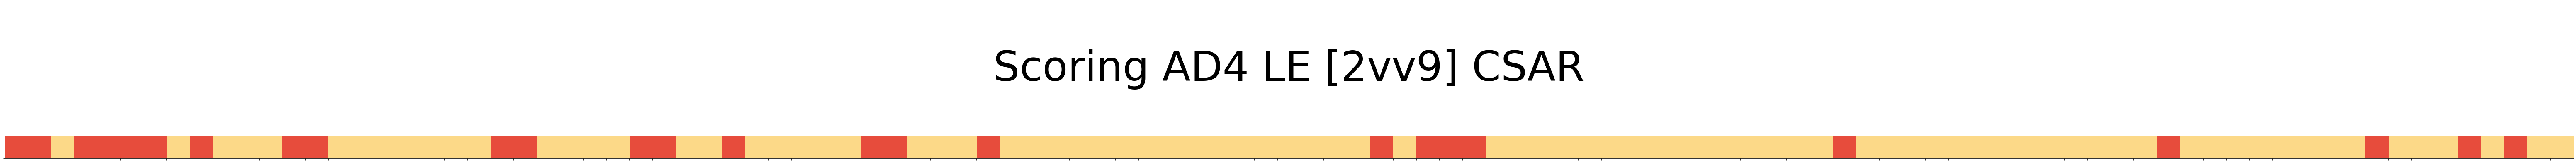

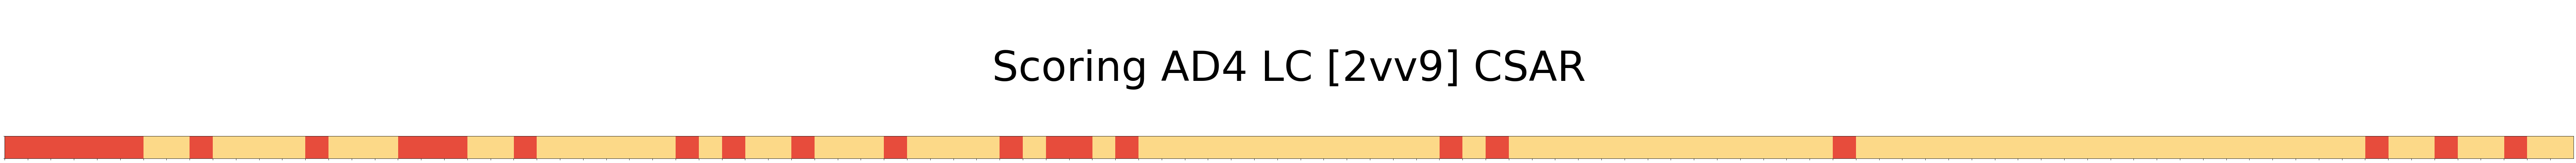

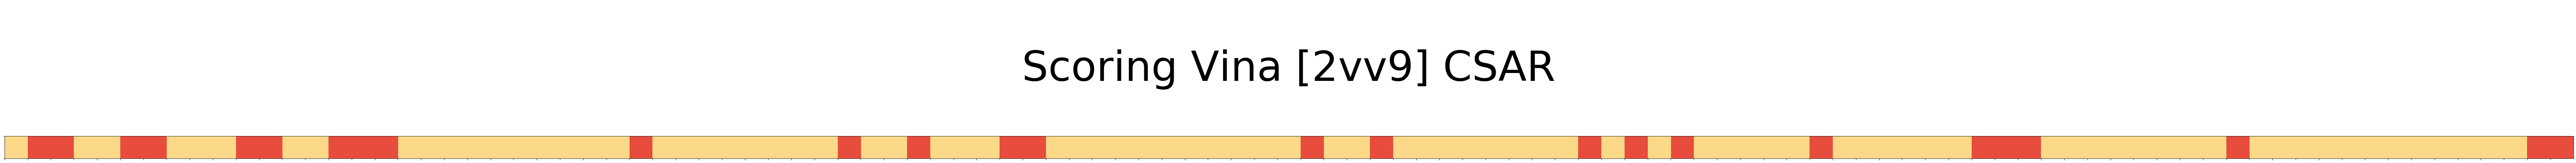

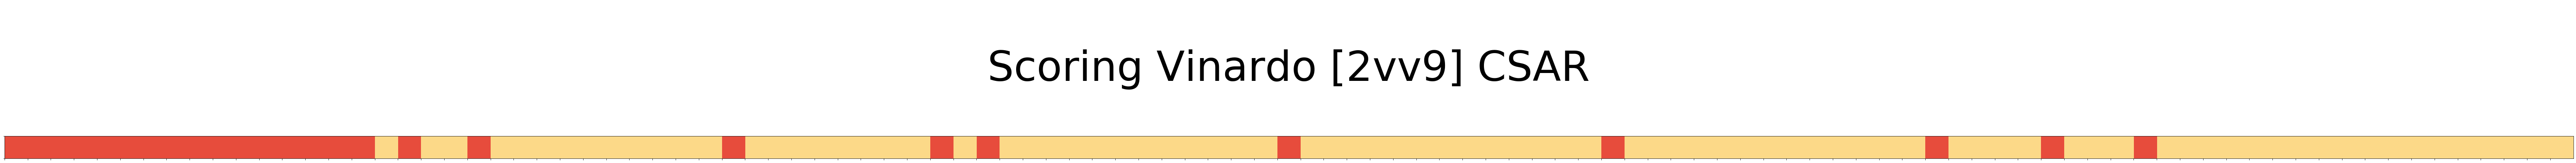

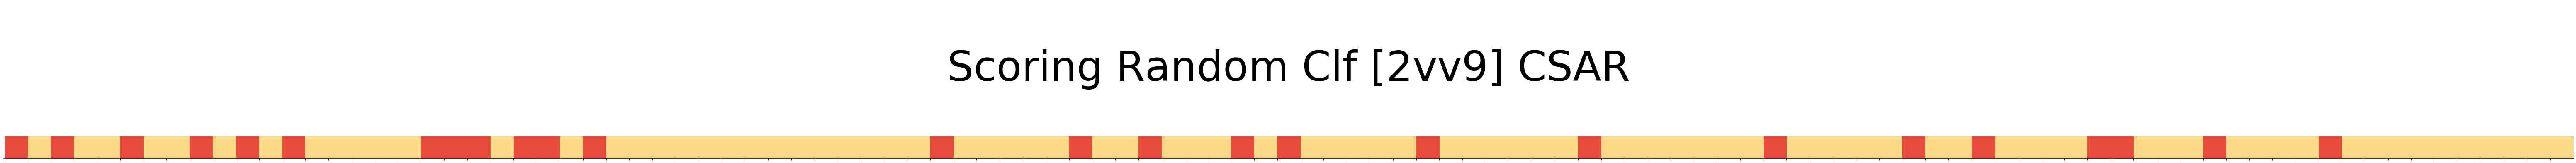

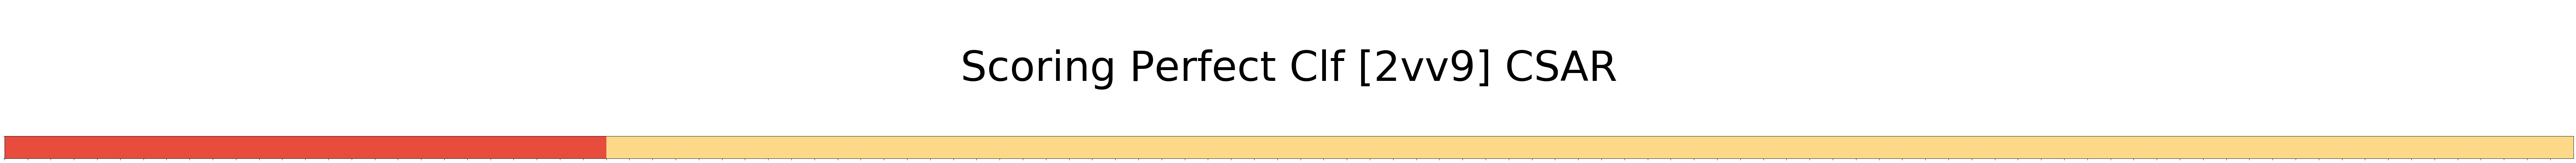

In [14]:
for dockTool, scores in dic_scores.items():
    plotActivesDistribution(true_values, scores, name = F'Scoring {dockTool} [{pdb_id}] CSAR')

---

# ROC-AUC

- Es independiente de la proporción de activos e inactivos.
- El valor de AUC va de 0 (peor preformance) a 1 (mejor preformance).
- Cuando el AUC = 0.5, el ranking es equivalente a una selacción aleatoria entre activos e inactivos, mostrando una distribución uniforme entre estos.
- El valor del AUC puede interpretarse como la probabilidad de un activo elegido al azar sea rankeado antes de un inactivo.

Es calculado de la siguiente manera (para *rankings* de scores):

$$
\begin{aligned}
ROC = \frac{1}{nN}\sum_{k = 2}^{N}F_a (k) [F_i(k) - Fi(k) - 1] \\
    = \sum_{k = 2}^{N} \frac{F_a (k)}{n} * \frac{[F_i(k) - Fi(k) - 1]}{N} \\
    = \sum_{k = 2}^{N} TPR * FPR \\
    = \sum_{k = 2}^{N} Recall(k) * (1 - Specificity(k))
\end{aligned}
$$

> donde $n$ es el número de moléculas activas (Positivos), $N$ es el total de moléculas evaluadas, $F_a(k)$ y $F_i(k)$ es la cuenta acumulada de activos e inactivos, respectivamente, hasta la posición $k$ del ranking.


In [15]:
# Librerías para calcular las ROC y el AUC
from sklearn.metrics import roc_curve, roc_auc_score

def get_AUC(y_true, y_pred, decreasing = True):
    y_pred = y_pred if not decreasing else (- 1 * y_pred)
    return  roc_auc_score( y_true = true_values, y_score = y_pred)

In [217]:
type(true_values) is np.ndarray

True

Calculamos el **ROC-AUC** tomando en cuenta los *rankings* de cada programa de *docking* a partir del promedio de los ranking por conformación.

### Visualización
**Gráficas de las curvas ROC.**

In [178]:
# Establecemos los parámetros para graficar
import pylab
pylab.rcParams['figure.figsize'] = (7,7)
sns.set( context = 'talk', style = 'white', palette = "Set2")

def add_plot_roc(predicted_values, true_values, label = '', linestyle = '-'):
    inverted_input = np.negative(predicted_values)
    fpr, tpr, thresholds = roc_curve(true_values, inverted_input)
    auc = roc_auc_score( y_true = true_values, y_score = inverted_input)
    plt.plot(fpr, tpr, label= label + ' AUC = %0.2f' % auc, lw = 3, linestyle = linestyle)

def plot_roc(predicted_values = None, true_values = None, label = '', titulo = "ROC curve", linestyle = '-'):
    sns.color_palette("Paired")
    if predicted_values is not None and true_values is not None:
        add_plot_roc(predicted_values, true_values, label, linestyle)
    plt.legend(fontsize='small')
    plt.plot([0, 1], [0, 1], 'k--', c = 'gray')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

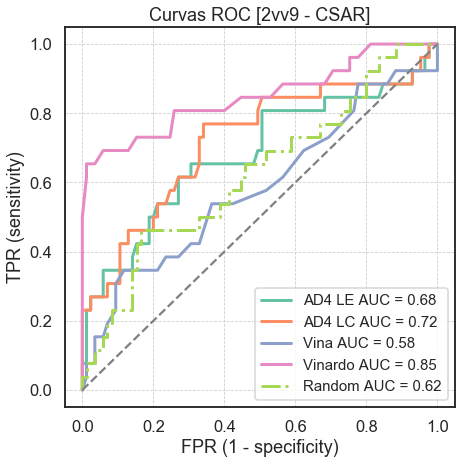

In [179]:
for dockTool, scores in dic_scores.items():
    if dockTool[-3:] != 'Clf':
        add_plot_roc(scores, true_values, label = F'{dockTool}')
plot_roc(y_score_RANDOM, true_values, "Random", F"Curvas ROC [{pdb_id} - CSAR]", linestyle = '-.')

In [18]:
format_metric(metric = get_AUC, metric_name = 'AUC ROC', 
              y_true = true_values, dic_y_preds = dic_scores).T

AUC ROC
AD4 LE         0.681
AD4 LC         0.719
Vina           0.584
Vinardo        0.849
Random Clf     0.624
Perfect Clf    1.000

### Desventajas de ROC-AUC
- Turchon y Bayly muestran que en realidad si hay una dependencia de la métrica con respecto a la proporción de activos/inactivos.
- Que ROC-AUC no es una buena métrica para el VS, pues no permite abordar el problema de 'early recognition'. Es decir, al tomar en cuenta toda la distribución de activos en el *ranking*, ROC-AUC no es capaz de distinguir *rankings* que podrían ser más convenientes en procedimiento de VS, donde la prioridad no es realmente rankear todos los posibes activos en la primer parte del ranking, sino garantizar que al menos una pequeña proporción de los activos quede al principio (en el *top*) del *ranking*. Pues, en la práctica, sólo una pequeña proporción de los compuestos rankeados será evaluada experimentalmente.
- Turchon y Bayly proponen los siguientes tres casos de *rankings* que explican por qué ROC-AUC no es una buena métrica para abordar el problema de 'early recognition'.

#### Los tres casos mencionados por Turchon y Bayly
- **Caso 1**: La mitad de los activos se ubica al principio del *ranking*, mientras que la otra mitad se encuentra al final.
- **Caso 2**: Todos los activos se distribuyen justo a la mitad del ranking.
- **Caso 3**: Los activos e inactivos se encuentran uniformemente distribuidos.

In [20]:
n = len(true_values[true_values == 1])
N = len(true_values)

In [ ]:
# 

### Casos adaptados a CSAR

In [210]:
def get_three_ranking_cases(true_values):
    '''Returns a dictionary of three ranking cases. Each value of the dictionary is 
    a numpy array of N scores which value depends on the case it belongs.
    '''
    n = len(true_values[true_values == 1])
    N = len(true_values)
    
    case_1 = np.zeros(N)
    for i, active in enumerate(true_values):
        if active:
            case_1[i] = -3 if i <= n/2 else -1
        else:
            case_1[i] = -2
            
    case_2 = np.zeros(N)
    n_negativos = 0
    for i, active in enumerate(true_values):
        if active:
            case_2[i] = -2
            continue
        n_negativos += 1
        if n_negativos <= (N - n)/2:
            case_2[i] = -3
        else:
            case_2[i] = -1
            
    case_3 = np.zeros(N)
    n_negativos, n_counter = 0, 0
    n_activos = 0
    for i, active in enumerate(true_values):
        if active:
            n_activos += 1
            case_3[i] = n_activos
            continue
        if n_negativos%np.floor(N/n) == 0:
            case_3[i] = n_counter + 0.1
            n_counter += 1.25
        else:
            case_3[i] = n_counter + 0.1
        n_negativos += 1
        
    cases_dic = {'case_1': case_1,
                 'case_2': case_2,
                 'case_3': case_3}
    return cases_dic

In [211]:
cases_dic = get_three_ranking_cases(true_values)

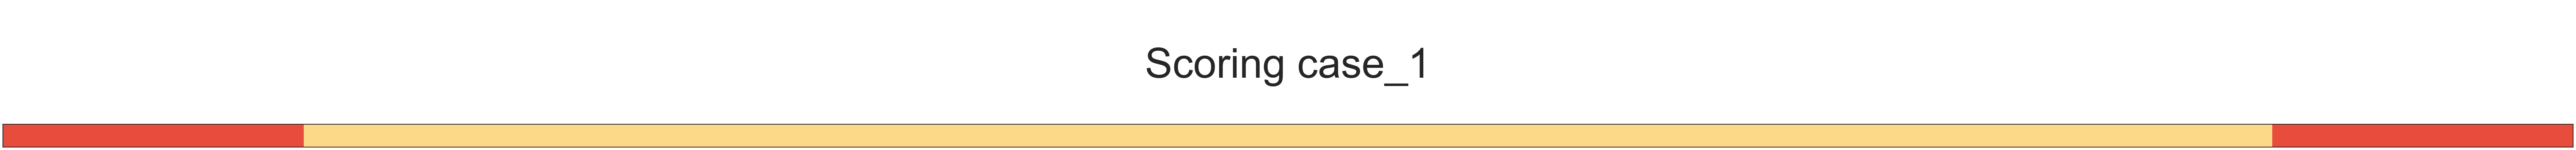

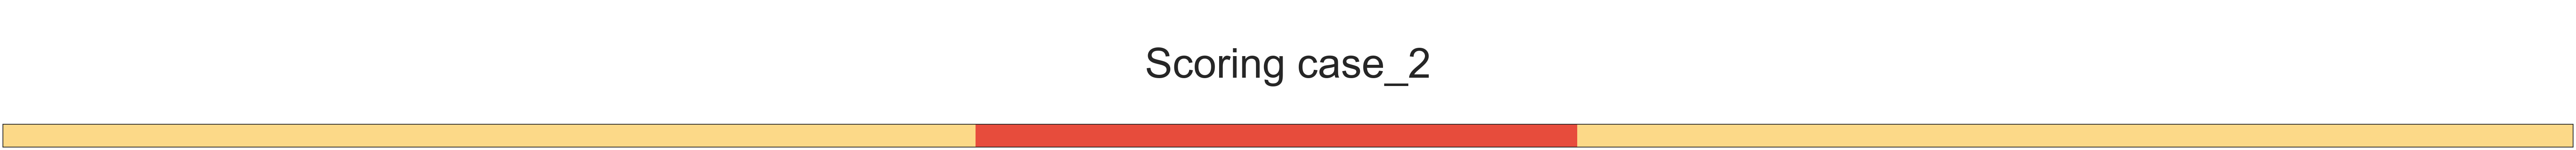

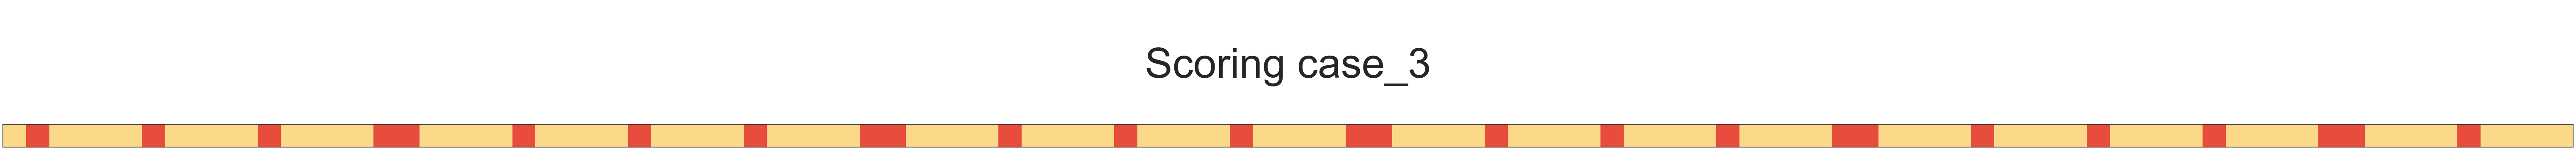

In [212]:
for dockTool, scores in cases_dic.items():
    plotActivesDistribution(true_values, scores,
                            name = F'Scoring {dockTool}')

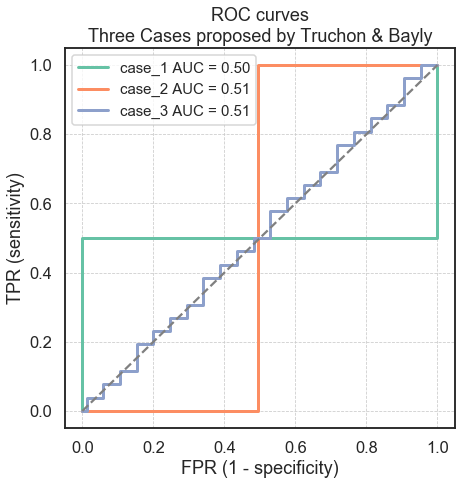

In [195]:
for dockTool, scores in cases_dic.items():
    add_plot_roc(scores, true_values, label = F'{dockTool}')
plot_roc(titulo = F"ROC curves\nThree Cases proposed by Truchon & Bayly", linestyle = '-.')

### Casos Adaptados a DUD

## Precision and Recall

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

In [197]:
from sklearn.metrics import precision_recall_curve, auc

def get_PR_AUC(y_true, y_pred, decreasing = True):
    y_pred = y_pred if not decreasing else (- 1 * y_pred)
    precision, recall, _ = precision_recall_curve(y_true = true_values, 
                           probas_pred = y_pred)
    pr_auc = auc(recall, precision)
    return  pr_auc

In [203]:
def add_plot_pr(predicted_values, true_values, label = '', linestyle = '-'):
    inverted_input = np.negative(predicted_values)
    precision, recall, thresholds = precision_recall_curve(y_true = true_values, 
                                                           probas_pred = inverted_input)
    auc_ = auc(recall, precision)
    plt.plot(recall, precision, label= label + ' AUC_PR = %0.2f' % auc_, lw = 3, linestyle = linestyle)

def plot_pr(predicted_values = None, true_values = None, label = '', 
            titulo = "Precision-Recall curve", linestyle = '-'):
    sns.color_palette("Paired")
    if predicted_values is not None:
        add_plot_pr(predicted_values, true_values, label, linestyle)
    plt.legend(fontsize = 'x-small')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    no_skill = len(true_values[true_values == 1]) / len(true_values)
    plt.plot([0, 1], [no_skill, no_skill], 'k--')
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

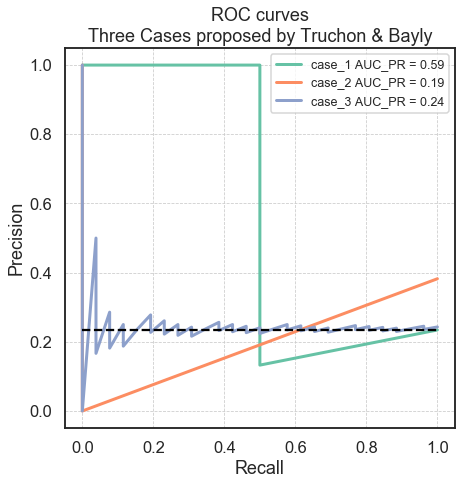

In [207]:
for dockTool, scores in cases_dic.items():
    add_plot_pr(scores, true_values, label = F'{dockTool}')
plot_pr(true_values = true_values, 
        titulo = F"ROC curves\nThree Cases proposed by Truchon & Bayly", linestyle = '-.')

In [208]:
format_metric(metric = get_PR_AUC, metric_name = 'AUC Precision-Recall', 
              y_true = true_values, dic_y_preds = cases_dic).T

AUC Precision-Recall
case_1                 0.592
case_2                 0.191
case_3                 0.236

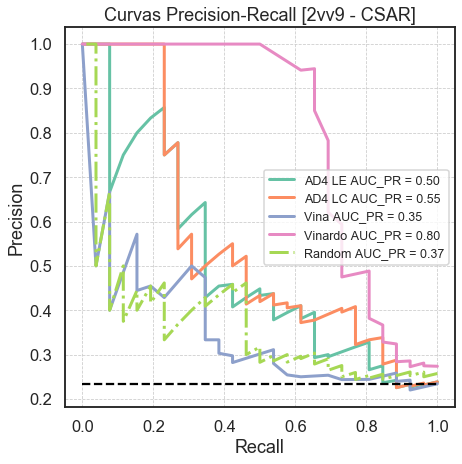

In [206]:
for dockTool, scores in dic_scores.items():
    if dockTool[-3:] != 'Clf':
        add_plot_pr(scores, true_values, label = F'{dockTool}')
plot_pr(y_score_RANDOM, true_values, "Random", 
        F"Curvas Precision-Recall [{pdb_id} - CSAR]", linestyle = '-.')

In [20]:
format_metric(metric = get_PR_AUC, metric_name = 'AUC Precision-Recall', 
              y_true = true_values, dic_y_preds = dic_scores).T

AUC Precision-Recall
AD4 LE                      0.498
AD4 LC                      0.548
Vina                        0.350
Vinardo                     0.799
Random Clf                  0.209
Perfect Clf                 1.000

## Problema de reconocimiento temprano

## Enrichment Factor

El factor de enriquecimiento mide la fracción de $n$ moléculas activas (verdaderos positivos) encontrados dentro de un porcentaje inicial del *ranking* de los valores predichos de las $N$ moléculas. Esto permite resolver el problema de comparar reultados del clasificador sobre datasets con diferentes proporciones de activos e inactivos.

EF se calcula de la siguiente manera:

$$EF(\chi) = \frac{n_s*N}{N_s*n}$$

donde $\chi$ es la proporción del número de ligandos a ser considerada. 

$$\chi = N_s/N$$

> y $N_{s}$ corresponde al número de moléculas del total de $N$ que conforman la fracción $\chi$. Y $n_s$ es el número de ligandos activos dentro de $N_s$. Es decir, $\chi*100$ equivale al porcentaje del total de $N$ moléculas que se tendrá en cuenta para la evaluación.

Otra manera de plantearlo es la siguiente:

$$EF_{X\%} = \frac{\textrm{# de activos a un X%}} {\textrm{# de moléculas a un X%}} * \frac{N}{n}$$

Por lo tanto, $\chi$ (o $X\%$) debe ser establecido por el investigador.

El valor máximo que puede tomar es $1/\chi$ si $\chi \geq n/N$, o $N/n$ si $\chi < n/N$.Y su valor mínimo es 0.

La idea es comparar qué tan enriquecido en activos está la primer parte del *ranking* de predichos, de un tamaño equivalente a un $X\%$ del total de moléculas, con respecto al enriquecimiento de un conjunto de $X\%$ del total de moléculas cuyos elementos se eligieron aleatoriamente:

Del artículo de Truchon y Bayly:
> *This metric has the advantage of answering the question: how enriched in actives will the set of 300 compounds that I select for screening be compared to the case where I would just pick the 300 compounds randomly? This is relevant only if the database is of considerable size (N > 300).*

Desventajas:
$EF$ se ve afectado por la proporción de activos en el *dataset*. Con lo cual, cuando muy pocos activos en el dataset la métrica se vuelve muy sensible a pequeñas variaciones en las posiciones de los activos dentro de la fracción $\chi$.

$EF$ además, otorga el mismo peso a los activos dentro de $N_s$, con lo cual no sería capaz de encontar diferencias entre los siguientes dos rankings de ejemplo:

1. (1, 1, 0, 0, 0 | ... ),  ranking 1 con $N_s = 5$
2. (0, 0, 0, 1, 1 | ... ),  ranking 2 con $N_s = 5$

Lo anterior dificulta que el $EF$ sea capaz de distinguir entre buenos clasificadores y excelentes clasificadores ([Truchon J-F, Bayly CI]()).

In [21]:
from rdkit.ML.Scoring.Scoring import CalcEnrichment

def get_EF(y_true, y_pred, fractions = [0.005, 0.01, 0.02, 0.05], 
                   decreasing = True, relative = False):
    N = len(y_true)
    n = sum(y_true == 1)
    if decreasing:
        order = np.argsort(y_pred)
    else:
        order = np.argsort(- y_pred)
    y_pred_ord = y_pred[order]
    y_true_ord = y_true[order]
    
    efs = []
    N_s_floor = [np.floor(N * f) for f in fractions]
    n_s = 0
    for n_mol in range(N):
        if n_mol > (N_s_floor[0]) and n_mol > 0:
            N_s = n_mol
            if relative: ef_i = (100 * n_s) / min(N_s, n)
            else: ef_i = (N * n_s) / (n * N_s)
            efs.append(ef_i)
            N_s_floor.pop(0)
        active = y_true_ord[n_mol]
        if active:
            n_s += 1
    # Checks if
    if N_s_floor and N_s_floor[0] == N:
        if relative: 
            ef_i = (100 * n) / n
            efs.append(ef_i)
        else: efs.append(1.0)
    return efs

def get_REF_AUC(y_true, y_pred):
    if not np.array_equal(y_true, y_true.astype(bool)):
        assert 'y_true array must be binary'
    fractions = np.linspace(0.0, 1, len(y_true) - 2 )
    efs = get_EF(y_true = y_true, y_pred = y_pred, 
                 fractions = fractions, relative = True)
    efs_auc = auc(fractions, efs)
    return efs_auc

In [22]:
ef_results = {}
fractions = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.99, 1.0]
for dockTool, score in dic_scores.items():
    ef_results[dockTool] = get_EF(y_true = true_values, 
                                  y_pred = score, fractions = fractions)
row_names_ef = [F'EF at {i*100}%' for i in fractions]
df_efs = pd.DataFrame(ef_results, index = row_names_ef)
df_efs["#ligs at X%"] = [(i* len(true_values)) for i in fractions]
df_efs.round(2)

AD4 LE  AD4 LC  Vina  Vinardo  Random Clf  Perfect Clf  \
EF at 1.0%      4.27    4.27  2.13     4.27        0.00         4.27   
EF at 2.0%      2.85    4.27  2.85     4.27        0.00         4.27   
EF at 5.0%      3.56    4.27  2.13     4.27        0.00         4.27   
EF at 10.0%     2.49    2.49  2.13     4.27        0.36         4.27   
EF at 25.0%     1.83    1.83  1.52     2.74        0.91         3.96   
EF at 50.0%     1.30    1.52  1.07     1.68        0.99         1.98   
EF at 99.0%     1.01    1.01  0.97     1.01        1.01         1.01   
EF at 100.0%    1.00    1.00  1.00     1.00        1.00         1.00   

              #ligs at X%  
EF at 1.0%           1.11  
EF at 2.0%           2.22  
EF at 5.0%           5.55  
EF at 10.0%         11.10  
EF at 25.0%         27.75  
EF at 50.0%         55.50  
EF at 99.0%        109.89  
EF at 100.0%       111.00

In [23]:
def add_plot_EF(predicted_values, true_values, label = '', linestyle = '-', relative = False):
    fractions = np.linspace(0.01, 1, len(predicted_values) - 2)
    efs = get_EF(y_true = true_values, y_pred = predicted_values, 
                 fractions = fractions, relative = relative)
    if relative: 
        auc_ = get_REF_AUC(true_values, predicted_values)
        label = label + ' AUC-REF = %0.2f' % auc_
    plt.plot(fractions, efs, label= label, lw = 3, linestyle = linestyle)

def plot_EF(predicted_values, true_values, label = '', 
            titulo = "Enrichment Factor curve", linestyle = '-', relative = False):
    sns.color_palette("Paired")
    n = len(true_values[true_values == 1])
    N = len(true_values)
    if not relative:
        plt.plot([n/N, n/N], [0 , N/n], 'k--', c = 'grey')
        plt.plot([0, 1], [1, 1], 'k--', c = 'grey')
    add_plot_EF( predicted_values, true_values, label, linestyle, relative)
    plt.legend(fontsize = 'small')
    plt.xlabel("Fracción del Ranking")
    plt.ylabel("Enrichment Factor")
    no_skill = len(true_values[true_values == 1]) / len(true_values)
    # Comportamiento del valor máximo con un clasificador ideal
    add_plot_EF( -1*true_values, true_values, label = 'Valor Máximo', 
                linestyle = '--', relative = relative)
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

R_a = n/N = 0.234
Valor máximo de EF cuando X (chi) < n/N: 4.269


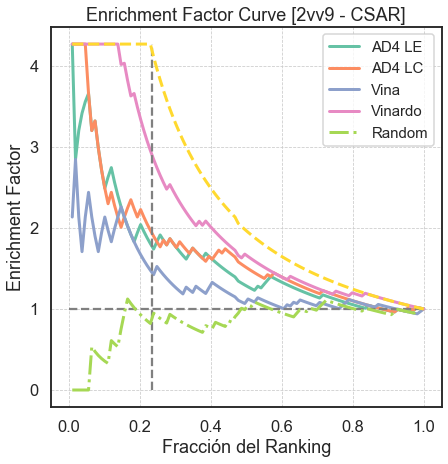

In [24]:
n = len(true_values[true_values == 1])
N = len(true_values)
r_a = n/N
print('R_a = n/N = %.3f' % r_a)
print('Valor máximo de EF cuando X (chi) < n/N: %.3f' % (N/n))

for dockTool, scores in dic_scores.items():
    if dockTool[-3:] != 'Clf':
        add_plot_EF(scores, true_values, label = F'{dockTool}')
plot_EF(y_score_RANDOM, true_values, "Random", 
        F"Enrichment Factor Curve [{pdb_id} - CSAR]", linestyle = '-.')

Cuando $\chi \geq n/N$ el valor máximo de $EF$ es $1/\chi$. Por lo tanto, cuando $\chi >> 1$, $1/X = 1/1$. Así, al contemplar todo el *ranking* (los 111 ligandos) el valor  máximo que $EF$ obtiene tiende a 1.


### Relative Enrichment Factor

In [25]:
ref_results = {}
fractions = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.99, 1.0]
for dockTool, score in dic_scores.items():
    ref_results[dockTool] = get_EF(y_true = true_values, 
                                  y_pred = score, fractions = fractions, relative = True)
row_names_ef = [F'REF at {i*100}%' for i in fractions]
df_refs = pd.DataFrame(ef_results, index = row_names_ef)
df_refs["#ligs at X%"] = [(i* len(true_values)) for i in fractions]
df_refs.round(2)

AD4 LE  AD4 LC  Vina  Vinardo  Random Clf  Perfect Clf  \
REF at 1.0%      4.27    4.27  2.13     4.27        0.00         4.27   
REF at 2.0%      2.85    4.27  2.85     4.27        0.00         4.27   
REF at 5.0%      3.56    4.27  2.13     4.27        0.00         4.27   
REF at 10.0%     2.49    2.49  2.13     4.27        0.36         4.27   
REF at 25.0%     1.83    1.83  1.52     2.74        0.91         3.96   
REF at 50.0%     1.30    1.52  1.07     1.68        0.99         1.98   
REF at 99.0%     1.01    1.01  0.97     1.01        1.01         1.01   
REF at 100.0%    1.00    1.00  1.00     1.00        1.00         1.00   

               #ligs at X%  
REF at 1.0%           1.11  
REF at 2.0%           2.22  
REF at 5.0%           5.55  
REF at 10.0%         11.10  
REF at 25.0%         27.75  
REF at 50.0%         55.50  
REF at 99.0%        109.89  
REF at 100.0%       111.00

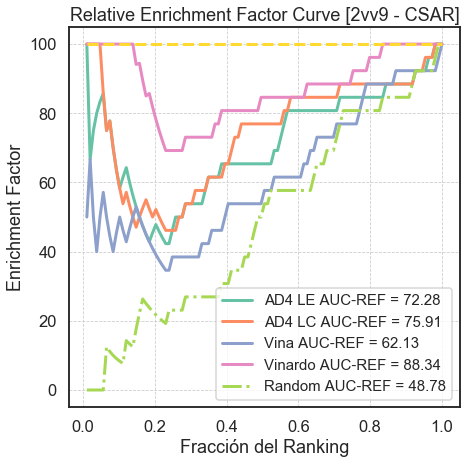

In [26]:
for dockTool, scores in dic_scores.items():
    if dockTool[-3:] != 'Clf':
        add_plot_EF(scores, true_values, label = F'{dockTool}', relative = True)
plot_EF(y_score_RANDOM, true_values, "Random", 
        F"Relative Enrichment Factor Curve [{pdb_id} - CSAR]", linestyle = '-.', relative = True)

In [28]:
format_metric(metric = get_REF_AUC, metric_name = 'AUC Relative Enrichment Factor', 
              y_true = true_values, dic_y_preds = dic_scores).T

AUC Relative Enrichment Factor
AD4 LE                               72.282
AD4 LC                               75.909
Vina                                 62.125
Vinardo                              88.337
Random Clf                           48.781
Perfect Clf                         100.000

## Robust Initial Enhancement

RIE es una métrica desarrolada por Sheridan, *et al*.  

Se basa en decrementar el peso que tiene cada uno de los activos en el *ranking* de predichos conforme se alejan de las posiciones iniciales. Por lo tanto, su peso depende de su posición ($r_i$). Así, los activos que aparecen más pronto en el rango ('*early recognition*') tienen mayor peso en valor de la métrica.

Es menos suceptible que $EF$ a tener grandes variaciones cuando la proporción de activos es muy baja.

La formula inicialmente propuesta es:

$$RIE = \frac{\sum_{i=1}^n e^{-\alpha r_i / N}} {\langle\sum_{i=1}^n e^{-\alpha r_i / N} \rangle_r},$$

> donde $n$ es el número de activos, $N$ es el número total de moléculas, $r_i$ es el rango de la $ith$ molécula activa en la lista ordenada de *predichos*. Algunas veces $r_i / N$ es expresado como $x_i$; el rango relativo. Finalmente $\alpha$ es un hiperparámetro relacionado con $\chi$ del $EF$ ($1/\alpha \approx \chi$).

En la ecuación anteriror, el denominador es el promedio de la suma del exponencial cuando un número $n$ de activos  está uniformemente distribuido en $N$ moléculas. Este término inicialmente era calculado con MonteCarlo, pues obtenerlo por fuerza bruta implicaba tomar en cuenta las $N!/(N-n)!n!$ combinaciones posibles. No obstante,  Truchon y Bayly proponen la siguiente formula para calcular $RIE$:

$$RIE = \frac{\sum_{i=1}^n e^{-\alpha r_i / N}} {\frac{n}{N} \left( \frac{1 - e^{-\alpha}}{e^{\alpha / N} - 1}\right) },$$

> donde el nuevo denominador fue determinado por Truchon y Bayly de forma analítica para aproximarse al término de la primera equación.

Al dar peso a todos los activos, $RIE$ tiene la ventaja sobre $EF$ de incluir la contribución de todos los activos en el score final (aunque mermando el peso de los activos que tienen posiciones más bajas en el *ranking*) .

Sus valores mínimos y máximos dependen de $n$, $N$ y $\alpha$, con lo cual no permite comparaciones con *datasets* de diferentes tamaños, como sí lo hace $EF$.

En resumen, $RIE$ tiene mayor ventaja que $ROC-AUC$ al abordar el problema de *early recognition*, y más ventaja sobre $REF$ al incluir la contribución de activos en todo el *ranking*, y no sólo en la fracción elegida. No obstante, si se van a comparar resultados con *datasets* de distinta proporción de activos/inactivos, $REF$ es una mejor opción.

Fuentes: https://sci-hub.tw/10.1021/ci600426e
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-10-225

In [62]:
from rdkit.ML.Scoring.Scoring import CalcRIE, CalcBEDROC
import warnings

def get_RIE(y_true, y_pred, alpha = 20):
    scores = np.array([y_true, y_pred]).T
    scores = scores[scores[:, 1].argsort()]
    rie = CalcRIE(scores, col=0, alpha = alpha)
    return rie

def get_BEDROC(y_true, y_pred, alpha = 20):
    r_a = (len(y_true[y_true == 1]))/len(y_true)
    "if alpha*r_a > 1, raises a warning and proposes the maximum alpha value = 1/r_a = N/n"
    if alpha*r_a >= 1:
        max_alpha = 1/r_a
        warnings.warn(F'Parsed alpha value times R_a is greater than 1. '\
                     + 'An alpha value below %0.2f is recomended.' % max_alpha)
    scores = np.array([y_true, y_pred]).T
    scores = scores[scores[:, 1].argsort()]
    bedroc = CalcBEDROC(scores, col=0, alpha = alpha)
    return bedroc

In [87]:
bedroc_results = {}
alphas = [100.0, 20.0, 4.0, 2.0, 1.0, 0.5]
for dockTool, score in dic_scores.items():
    bedroc_results[dockTool] = \
        [get_BEDROC(y_true = true_values, 
         y_pred = score, alpha = a) for a in alphas]
row_names_br = [F'alpha = {a}' for a in alphas]
df_bedroc = pd.DataFrame(bedroc_results, index = row_names_br)
df_bedroc.round(3).T

/home/linuxlite/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Parsed alpha value times R_a is greater than 1.An alpha value below 4.27 is recomended.
  app.launch_new_instance()


alpha = 100.0  alpha = 20.0  alpha = 4.0  alpha = 2.0  \
AD4 LE               0.901         0.692        0.606        0.636   
AD4 LC               0.996         0.747        0.636        0.671   
Vina                 0.349         0.465        0.484        0.525   
Vinardo              1.000         0.966        0.839        0.837   
Random Clf           0.001         0.089        0.291        0.371   
Perfect Clf          1.000         1.000        1.000        1.000   

             alpha = 1.0  alpha = 0.5  
AD4 LE             0.657        0.669  
AD4 LC             0.694        0.707  
Vina               0.553        0.568  
Vinardo            0.841        0.845  
Random Clf         0.418        0.442  
Perfect Clf        1.000        1.000

In [63]:
format_metric(metric = get_BEDROC, metric_name = 'BEDROC values at alpha 4', 
              y_true = true_values, dic_y_preds = dic_scores).T

4.085901135445424

In [64]:
get_RIE(y_true = true_values, y_pred = y_score_vina)

1.9674495266520962

In [74]:
get_BEDROC(y_true = true_values, y_pred = y_score_RANDOM, alpha = 0.5)

0.442273302756696

In [80]:
get_BEDROC(y_true = true_values, y_pred = y_score_vrd, alpha = 30)

/home/linuxlite/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Parsed alpha value times R_a is greater than 1.An alpha value below 4.27 is recomended.
  app.launch_new_instance()


0.9911566168343829

In [79]:
1/0.5

2.0

##  BEDROC: Boltzmann-Enhanced Discrimination of ROC

Depende del $RIE$, y al igual que él asigna más peso a las moléculas que están en el top del *ranking*.

Se calcula de la siguiente manera:

$$BEDROC = RIE * \frac{R_a e^{\alpha R_a} (e^{\alpha} -1)}{(e^{\alpha} - e^{\alpha R_a}) (e^{\alpha R_a} - 1)},$$

> donde $R_a = n /N$, siendo $n$ el número de activos, $N$ es el número total de moléculas.

A diferencia de $RIE$, los valores de $BEDROC$ van de 0 a 1, con lo cual puede interpretarse como la probabilidad de que, en el *ranking* de predichos, un activo sea rankeado antes de un compuesto $x$ elegido aleatoriamente.

> *Under the conditions $\alpha R_a << 1$ and $\alpha \neq 0$, the BEDROC metric is the probability that an active ranked by the evaluated method will be found before a compound that would come from a hypothetical exponential PDF with parameter $\alpha$.*

$BEDROC$ también depende del hiperparámetro $\alpha$, con el cual el usuario puede definir el tamaño de la fracción inicial del *ranking* a la que le dará más peso; recordar que $1/\alpha \approx \chi$.

Del artículo:
> *$1/\alpha$ can be understood as the fraction of the list where the weight is important.*

De https://new.pharmacelera.com/science/measuring-virtual-screening-accuracy/:
> *The exponential factor determines how much the BEDROC parameter focuses on the top of the list.*

Por lo tanto, para disminuir el error, se recomienda elegir el parámetro de $\alpha$ tal que $\alpha R_a << 1$.

Finalmente, los autores mencionan los siguiente con respecto a la elección de $\alpha$:

> *what is the baseline
enrichment from which you would consider a ranking method
useful in the context of a VS?*

Sólo para aclarar, `rdkit` calcula $BEDROC$ a parir de valores $RIE_{min}$ y $RIE_{max}$ cuyo cálculo es mencionado en el artículo de Truchon y Bayly.  El código fuente de rdkit es el siguiente: [rdkit.Scorings](https://github.com/rdkit/rdkit/blob/master/rdkit/ML/Scoring/Scoring.py)).

In [ ]:
def get_BEDROC(y_true, y_pred, alpha = 20):
    r_a = (len(y_true[y_true == 1]))/len(y_true)
    "if alpha*r_a > 1, raises a warning and proposes the maximum alpha value = 1/r_a = N/n"
    if alpha*r_a >= 1:
        max_alpha = 1/r_a
        warnings.warn(F'Parsed alpha value times R_a is greater than 1. '\
                     + 'An alpha value below %0.2f is recomended.' % max_alpha)
    scores = np.array([y_true, y_pred]).T
    scores = scores[scores[:, 1].argsort()]
    bedroc = CalcBEDROC(scores, col=0, alpha = alpha)
    return bedroc

In [157]:
bedroc_results = {}
alphas = [100.0, 20.0, 4.0, 2.0, 1.0, 0.5]
for dockTool, score in dic_scores.items():
    bedroc_results[dockTool] = \
        [get_BEDROC(y_true = true_values, 
         y_pred = score, alpha = a) for a in alphas]
row_names_br = [F'alpha = {a}' for a in alphas]
df_bedroc = pd.DataFrame(bedroc_results, index = row_names_br)
df_bedroc.round(3).T

/home/linuxlite/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Parsed alpha value times R_a is greater than 1. An alpha value below 4.27 is recomended.
  app.launch_new_instance()


alpha = 100.0  alpha = 20.0  alpha = 4.0  alpha = 2.0  \
AD4 LE               0.901         0.692        0.606        0.636   
AD4 LC               0.996         0.747        0.636        0.671   
Vina                 0.349         0.465        0.484        0.525   
Vinardo              1.000         0.966        0.839        0.837   
Random Clf           0.241         0.252        0.389        0.442   
Perfect Clf          1.000         1.000        1.000        1.000   

             alpha = 1.0  alpha = 0.5  
AD4 LE             0.657        0.669  
AD4 LC             0.694        0.707  
Vina               0.553        0.568  
Vinardo            0.841        0.845  
Random Clf         0.473        0.489  
Perfect Clf        1.000        1.000

## ROC enrichment (ROCe)

https://link.springer.com/article/10.1007/s10822-014-9753-z

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2270923/pdf/10822_2008_Article_9170.pdf

Es la fracción de compuestos activos ($n_{\chi}/n$) (recall/sensitivity = $TPR$) dividido por la fracción de falsos positivos ($FPR(\chi)$) a un determinado valor de porcentaje del *ranking* ($\chi*100$).

Se calcula de la siguiente manera:

$$ROCe(\chi) = \frac{TPR_{\chi}}{FPR_{\chi}} = \frac{n_{s}/n}{(N_s - n_s)/(N - n)} = \frac{n_s * (N - n)}{n * (N_s - n_s)},$$

> donde $N_{s}$ corresponde al número de moléculas del total de $N$ que conforman la fracción $\chi$ (recordar que: $\chi = N_s/N$). Y $n_s$ es el número de ligandos activos dentro de $N_s$.

De manera similar a $EF$, esta métrica resuelve el problema de poder comparar datasets con diferentes proporciones de activos/inactivos. Problema que presenta $BEDROC$ y $RIE$. Pero además también resuelve el problema de tasas muy bajas de activos/inactivos que presenta $EF$.

La desventaja es que el usuario debe definir el valor de $\chi$. Jain y Nicholls (Jain, AN; Nicholls, A. Recommendations for Evaluation of Computational Methods.) sugieren valores de 0.005 (0.5%), 0.01 (1%), 0.02 (2%) y 0.05 (5%).

In [45]:
def get_ROCe(y_true, y_pred, fractions = [0.005, 0.01, 0.02, 0.05], 
                   decreasing = True):
    N = len(y_true)
    n = sum(y_true == 1)
    if decreasing:
        order = np.argsort(y_pred)
    else:
        order = np.argsort(- y_pred)
    y_pred_ord = y_pred[order]
    y_true_ord = y_true[order]
    
    roce = []
    N_s_floor = [np.floor(N * f) for f in fractions]
    n_s = 0
    for n_mol in range(N):
        if n_mol > (N_s_floor[0]) and n_mol > 0:
            N_s = n_mol
            roce_i =  (n_s * (N - n)) / (n * (N_s - n_s))
            roce.append(roce_i)
            N_s_floor.pop(0)
        active = y_true_ord[n_mol] 
        if active:
            n_s += 1
    return roce

In [46]:
fractions = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.99]
ef_results = pd.DataFrame(
    {"AD4 LE": get_ROCe(y_true = true_values, y_pred = y_score_ad4_LE, 
                      fractions = fractions),     
    "AD4 LC": get_ROCe(y_true = true_values, y_pred = y_score_ad4_LC, 
                      fractions = fractions),
    "Vina": get_ROCe(y_true = true_values, y_pred = y_score_vina, 
                      fractions = fractions),
    "Vinardo": get_ROCe(y_true = true_values, y_pred = y_score_vrd, 
                      fractions = fractions),
    "Ideal": get_ROCe(y_true = true_values, y_pred = - true_values, 
                      fractions = fractions),
    "Random": get_ROCe(y_true = true_values, y_pred = y_score_RANDOM, 
                      fractions = fractions),
    "Número de ligandos a X% (N_s)": [(i* len(true_values)) for i in fractions]},
    index = [F'ROCe a {(i*100)}%' for i in fractions])

ef_results.round(2)

/home/linuxlite/anaconda3/envs/mds/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in long_scalars


AD4 LE  AD4 LC  Vina  Vinardo  Ideal  Random  \
ROCe a 1.0%      inf     inf  3.27      inf    inf    3.27   
ROCe a 2.0%     6.54     inf  6.54      inf    inf    1.63   
ROCe a 5.0%    16.35     inf  3.27      inf    inf    0.65   
ROCe a 10.0%    4.58    4.58  3.27      inf    inf    1.09   
ROCe a 25.0%    2.45    2.45  1.82     5.88  42.50    1.55   
ROCe a 50.0%    1.43    1.82  1.09     2.12   2.83    0.99   
ROCe a 99.0%    1.01    1.01  0.96     1.01   1.01    0.96   

              Número de ligandos a X% (N_s)  
ROCe a 1.0%                            1.11  
ROCe a 2.0%                            2.22  
ROCe a 5.0%                            5.55  
ROCe a 10.0%                          11.10  
ROCe a 25.0%                          27.75  
ROCe a 50.0%                          55.50  
ROCe a 99.0%                         109.89

In [92]:
def get_EF(y_true, y_pred, fractions = [0.005, 0.01, 0.02, 0.05], 
                   decreasing = True, relative = False):
    N = len(y_true)
    n = sum(y_true == 1)
    if decreasing:
        order = np.argsort(y_pred)
    else:
        order = np.argsort(- y_pred)
    y_pred_ord = y_pred[order]
    y_true_ord = y_true[order]
    
    efs = []
    N_s_floor = [np.floor(N * f) for f in fractions]
    n_s = 0
    for n_mol in range(N):
        if n_mol > (N_s_floor[0]) and n_mol > 0:
            N_s = n_mol
            if relative: ef_i = (100 * n_s) / min(N_s, n)
            else: ef_i = (N * n_s) / (n * N_s)
            efs.append(ef_i)
            N_s_floor.pop(0)
        active = y_true_ord[n_mol]
        if active:
            n_s += 1
    # Checks if
    if N_s_floor and N_s_floor[0] == N:
        if relative: 
            ef_i = (100 * n) / n
            efs.append(ef_i)
        else: efs.append(1.0)
    return efs

def get_REF_AUC(y_true, y_pred):
    if not np.array_equal(y_true, y_true.astype(bool)):
        assert 'y_true array must be binary'
    fractions = np.linspace(0.0, 1, len(y_true) - 2 )
    efs = get_EF(y_true = y_true, y_pred = y_pred, 
                 fractions = fractions, relative = True)
    efs_auc = auc(fractions, efs)
    return efs_auc

100.0

In [201]:
# Implementación de la curva BEDROC, no disponible en sklearn
import numpy as np

def bedROC_score(y_true, y_pred, decreasing = False, alpha = 20.0):
    assert len(y_true) == len(y_pred), 'The number of scores must be equal to the number of labels'
    
    N = len(y_true)
    n_true = sum(y_true == 1)

    if decreasing:
        order = np.argsort(- y_pred)
    else:
        order = np.argsort(y_pred)
    # Posición relativa de los verdaderos activos en el rango de los predichos
    m_rank = (y_true[order] == 1).nonzero()[0]
    
    s = np.sum(np.exp(-alpha * m_rank / N))
    # R_a es la proporción de verdaderos activos sobre el total (N) de ligandos
    r_a = n_true / N
    
    rand_sum = r_a * (1 - np.exp(-alpha))/(np.exp(alpha/N) - 1)

    fac = r_a * np.sinh(alpha / 2) / (np.cosh(alpha / 2) -
                                      np.cosh(alpha/2 - alpha * r_a))

    cte = 1 / (1 - np.exp(alpha * (1 - r_a)))

    return s * fac / rand_sum + cte

In [204]:
def bedROC_score(y_true, y_pred, decreasing = False, alpha = 20.0):
    assert len(y_true) == len(y_pred), \
        'The number of scores must be equal to the number of labels'

    big_n = len(y_true)
    n = sum(y_true == 1)

    if decreasing:
        order = np.argsort(-y_pred)
    else:
        order = np.argsort(y_pred)

    m_rank = (y_true[order] == 1).nonzero()[0]

    s = np.sum(np.exp(-alpha * m_rank / big_n))

    r_a = n / big_n

    rand_sum = r_a * (1 - np.exp(-alpha))/(np.exp(alpha/big_n) - 1)

    fac = r_a * np.sinh(alpha / 2) / (np.cosh(alpha / 2) -
                                      np.cosh(alpha/2 - alpha * r_a))

    cte = 1 / (1 - np.exp(alpha * (1 - r_a)))
    
    return s * fac / rand_sum + cte

In [102]:
def bedROC_score_jrl(y_true, y_pred, decreasing = False, alpha = 20.0):
    assert len(y_true) == len(y_pred), 'The number of scores must be equal to the number of labels'
    
    N = len(y_true)
    n_true = sum(y_true == 1)

    if decreasing:
        order = np.argsort(- y_pred)
    else:
        order = np.argsort(y_pred)
    # Posición relativa de los verdaderos activos en el rango de los predichos
    m_rank = (y_true[order] == 1).nonzero()[0] + 1
    print(m_rank)
    
    
    S_numerator = np.sum(np.exp(-alpha * m_rank / N))
    
    r_a = n_true / N
    
    _denominator =  (n_true / N) * ( (1 - np.exp(-alpha)) / (np.exp(alpha/N) - 1) )
    
    RIE = S_numerator / _denominator
    
    r_a_exp = np.exp(alpha*r_a)
    
    e_a = np.exp(alpha)
    r_ae = (r_a * r_a_exp * (e_a - 1)) / ((e_a - r_a_exp) * (r_a_exp - 1))
    
    n_N = (n_true / N) * ((1 - np.exp(- alpha)) / (np.exp(alpha / N) - 1))
    
    
    last = 1 / (1 - (np.exp(alpha * (1 - r_a))))
    print(RIE)
    return ((RIE) * (r_ae )) #+ last

### BEDROCS
https://github.com/deepchem/deepchem/issues/412

https://github.com/deepchem/deepchem/pull/1429

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-10-225

https://github.com/rdkit/rdkit/blob/master/rdkit/ML/Scoring/Scoring.py

In [65]:
roc_auc_score( y_true = true_values, 
              y_score = (- sc_promedio_ad4_LC))

0.6099547511312218

In [73]:
# Error cuando los scores tienen valores similares, como en el caso de vian y vianrdo
# https://github.com/rdkit/rdkit/pull/1306
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcAUC

y_true = true_values
y_pred = sorted(sc_promedio_ad4_LC)
scores = list(zip(y_true, y_pred))
#scores = sorted(scores, key=lambda x: x[1], reverse=False)
CalcAUC(scores, col=0)

0.609954751131222

In [19]:
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcROC, CalcRIE, _RIEHelper

In [49]:
def bedroc_score(y_true, y_pred, decreasing=True, alpha=20.0):

    """BEDROC metric implemented according to Truchon and Bayley.
    The Boltzmann Enhanced Descrimination of the Receiver Operator
    Characteristic (BEDROC) score is a modification of the Receiver Operator
    Characteristic (ROC) score that allows for a factor of *early recognition*.
    References:
        The original paper by Truchon et al. is located at `10.1021/ci600426e
        <http://dx.doi.org/10.1021/ci600426e>`_.
    Args:
        y_true (array_like):
            Binary class labels. 1 for positive class, 0 otherwise.
        y_pred (array_like):
            Prediction values.
        decreasing (bool):
            True if high values of ``y_pred`` correlates to positive class.
        alpha (float):
            Early recognition parameter.
    Returns:
        float:
            Value in interval [0, 1] indicating degree to which the predictive
            technique employed detects (early) the positive class.
     """

    assert len(y_true) == len(y_pred), \
        'The number of scores must be equal to the number of labels'

    big_n = len(y_true)
    n = sum(y_true == 1)

    if decreasing:
        order = np.argsort(-y_pred)
    else:
        order = np.argsort(y_pred)

    m_rank = (y_true[order] == 1).nonzero()[0] + 1

    s = np.sum(np.exp(-alpha * m_rank / big_n))

    r_a = n / big_n

    rand_sum = r_a * (1 - np.exp(-alpha))/(np.exp(alpha/big_n) - 1)

    fac = r_a * np.sinh(alpha / 2) / (np.cosh(alpha / 2) -
                                      np.cosh(alpha/2 - alpha * r_a))

    cte = 1 / (1 - np.exp(alpha * (1 - r_a)))
    
    return s * fac / rand_sum + cte

In [150]:
y_true = true_values
y_pred = df_vinardo_results['2vv9']
scores = list(zip(y_true, y_pred))
scores = sorted(scores, key=lambda x: x[1], reverse=False)
print(_RIEHelper(scores, col=0, alpha = 20))
CalcBEDROC(scores, col=0, alpha = 20)

(4.073542445749515, 26)


0.9630575441036651

In [758]:
####*** Opción con rdkit, el ordenamiento tiene que hacerse con numpy
y_true = true_values
y_pred = df_vinardo_results['2vv9']

scores = np.array([y_true, y_pred]).T
scores = scores[scores[:, 1].argsort()]
print(_RIEHelper(scores, col=0, alpha = 20))
CalcBEDROC(scores, col=0, alpha = 20)

(4.085901135445424, 26)


0.9659793577986313

In [115]:
bedROC_score_jrl(y_true = true_values, y_pred = df_vinardo_results['2vv9'], 
             decreasing = False, alpha = 20.0)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 21 32 41 43 56 70 84
 89 93]
4.085901135445424


0.9659795809724101

In [100]:
bedroc_score(y_true = true_values, y_pred = df_vinardo_results['2vv9'], 
             decreasing = False, alpha = 20.0)

0.9659793577986313

In [205]:
CalcRIE(scores, col=0, alpha = 20)


2.312005886407023

In [92]:
bedROC_score(y_true = true_values, y_pred = sc_promedio_vrd, decreasing = False, alpha = 20.0)

0.9179338936036573

In [57]:
df_vinardo_results[ '2vv9' ].to_numpy()

array([ -7.1,  -7.8,  -7.3,  -8.1,  -7.7,  -8.9,  -8.7,  -8.7,  -7.5,
        -9.7,  -9.6,  -9.7, -10. , -10.5, -10. ,  -9.9, -10.1,  -7.7,
        -8.8,  -9.1,  -8.3,  -7.6,  -8.8,  -9.5,  -8.1,  -7.4,  -7.8,
        -7.4,  -7.8,  -8.5,  -7. ,  -7.4,  -7.9,  -7.7,  -8.3,  -6.8,
        -8.4,  -8.8,  -8. ,  -6.9,  -9.1,  -7.8,  -7.1,  -7. ,  -8.4,
        -5.7,  -6.8,  -8.4,  -8.8,  -7.9,  -9.1,  -8.8,  -7.6,  -8.7,
        -7.6,  -8.5,  -8.4,  -8.6,  -8.8,  -8. ,  -7.7,  -9.3,  -8.9,
        -9.4,  -8.4,  -7.5,  -7.2,  -5.7,  -8.8,  -6.1,  -9. ,  -8.1,
        -6.6,  -7.5,  -7.2,  -8.9,  -9.3,  -7.7,  -6.9,  -7. ,  -7.9,
        -8.1,  -7.6,  -6.1,  -8.6,  -6.4,  -6.9,  -7.6,  -6.6,  -8. ,
        -8.5,  -7.1,  -8.8,  -7.1,  -7.4,  -6.3,  -9.7,  -8.1,  -9.2,
        -7.9,  -9.2,  -9.7, -10. , -10.6, -10.1, -10.5, -11. , -10. ,
        -9.3, -10.8, -10.1])

In [200]:
bedROC_score(y_true = true_values, y_pred = true_values, 
             decreasing = False, alpha = 20.0)

1.1303536279799164e-06


2.67235669124346e-07

In [54]:
bedROC_score(y_true = true_values, y_pred = sc_promedio_vina, decreasing = False, alpha = 20.0)

0.5937582435706807

In [43]:
bedROC_score(y_true = true_values, y_pred = sc_promedio_ad4_LE, decreasing = False, alpha = 20.0)

0.6015647630518797

In [44]:
bedROC_score(y_true = true_values, y_pred = sc_promedio_ad4_LC, decreasing = False, alpha = 20.0)

0.8901861661672413

## Probando *scoring consensus* más comunes

**Fuente:** _[Exponential consensus ranking improves the outcome in docking and receptor ensemble docking](https://www.nature.com/articles/s41598-019-41594-3)_

### ROC con valores promedio (Rank-by-number)
Gráfica **ROC** con valores promedio.
> El score final de cada ligando ($R_bN_i$) corresponde al *score* promedio de cada ligando $i$ en todas las $n$ conformaciones:

> $R_bN_i = \frac{1}{n}\sum_js_i^j,$

donde $n$ es el número de conformaciones, y $s_i^j$ es el score de la molécula $i$ con la conformación $j$.

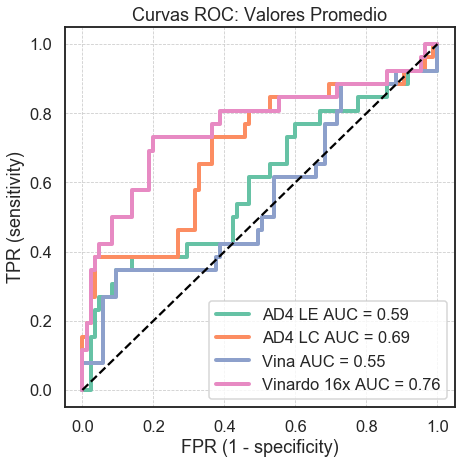

In [13]:
add_plot_roc(sc_promedio_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_promedio_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_promedio_vina, true_values, "Vina")
#add_plot_roc(sc_promedio_vrd_8x, true_values, "Vinardo 8x")
plot_roc(sc_promedio_vrd, true_values, "Vinardo 16x", "Curvas ROC: Valores Promedio")

### ROC con mejores *scores* de cada método
Gráficas **ROC**, si para el **ranking** final extrajeramos el mejor score de cada ligando, es decir, de los $n$ scores obtenidos para una molécula $i$, nos quedamos con el mínimo:

> $best\ score_i = min(s_i),$

donde $s_i$ es un vector de $n$ scores donde cada posición $j$ corresponde al score entre la molécula $i$ y la conformación $j$.

In [14]:
# Scorings mínimos (mejores) de cada ligando
sc_minimo_vrd = np.array(df_vinardo_results.min(axis=1))
sc_minimo_vina = np.array(df_vina_results.min(axis=1))
sc_minimo_ad4_LE = np.array(df_ad4_results_LE.min(axis=1))
sc_minimo_ad4_LC = np.array(df_ad4_results_LC.min(axis=1))

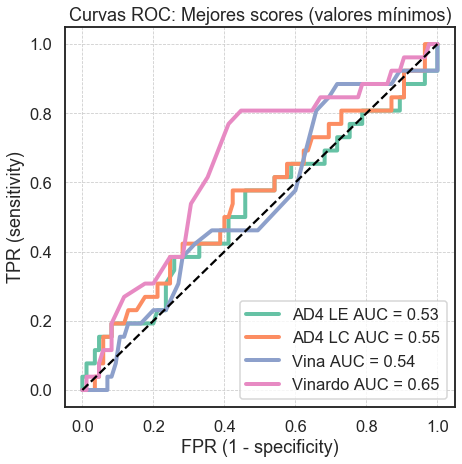

In [15]:
add_plot_roc(sc_minimo_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_minimo_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_minimo_vina, true_values, "Vina")
plot_roc(sc_minimo_vrd, true_values, "Vinardo", "Curvas ROC: Mejores scores (valores mínimos)")

### ROC *rank-by-rank*
Gráfica **ROC** con valores de rango por rango.
> Pra cada conformación $j$ las $m$ moléculas son rankeadas (ordenadas) y a la molécula con el mejor scoring se le asigna el valor de 1 mientras que a la molécula en la posición $m$ se le asigna el valor $m$. Posteriormente se obtiene la media de los valores d erango de cada molécula en las $n$ conformaciones.

> $R_bR_i = \frac{1}{n}\sum_jr^i_j,$

donde $n$ es el número de conformaciones, y $r^i_j$ es la posición de la molécula $i$ en el rango de la conformación $j$.

In [16]:
def get_rank_by_rank(df):
    df_ranks = df.rank() # Obtenemos los rankings de cada ligando
    # Para cada ligando i se obtiene la media de su valor en las n conformaciones
    df_rank_by_rank = np.array(df_ranks.mean(axis = 1))
    return(df_rank_by_rank)

In [17]:
r_by_r_vrd = get_rank_by_rank(df_vinardo_results.drop(['ActiveInactive'], axis = 1))
r_by_r_vina = get_rank_by_rank(df_vina_results.drop(['ActiveInactive'], axis = 1))
r_by_r_ad4_LE = get_rank_by_rank(df_ad4_results_LE.drop(['ActiveInactive'], axis = 1))
r_by_r_ad4_LC = get_rank_by_rank(df_ad4_results_LC.drop(['ActiveInactive'], axis = 1))

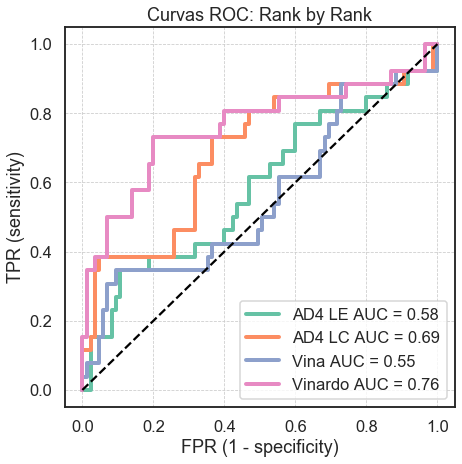

In [18]:
add_plot_roc(r_by_r_ad4_LE, true_values, "AD4 LE")
add_plot_roc(r_by_r_ad4_LC, true_values, "AD4 LC")
add_plot_roc(r_by_r_vina, true_values, "Vina")
plot_roc(r_by_r_vrd, true_values, "Vinardo", "Curvas ROC: Rank by Rank")

### ROC z-score
> Estandarización por conformación (columna). El *score* $s_i^j$ de la molécula $i$ en la conformación $j$ es estandarizado. Es decir, usamos la media de los $m$ scores en la conformación j ($\mu^j$) y su desviación estándar ($\sigma^j$). Posteriormente se obtiene la media de todos los scores estandarizados de la molécula $i$:

> $z-score_i = \frac{1}{n}\sum_j\frac{s_i^j - \mu^j}{\sigma^j}$

In [19]:
from sklearn.preprocessing import StandardScaler

def get_zscore(df):
    means = df.mean(axis=0) # media por columna
    stds = df.std(axis=0) # std por columna
    # df_centered_values = (df - means)/stds
    df_centered_values = StandardScaler().fit_transform(df)
    z_score =  df_centered_values.mean(axis=1)
    return(z_score)

In [20]:
z_score_vrd = get_zscore(df_vinardo_results.drop(['ActiveInactive'], axis = 1))
z_score_vina = get_zscore(df_vina_results.drop(['ActiveInactive'], axis = 1))
z_score_ad4_LE = get_zscore(df_ad4_results_LE.drop(['ActiveInactive'], axis = 1))
z_score_ad4_LC = get_zscore(df_ad4_results_LC.drop(['ActiveInactive'], axis = 1))

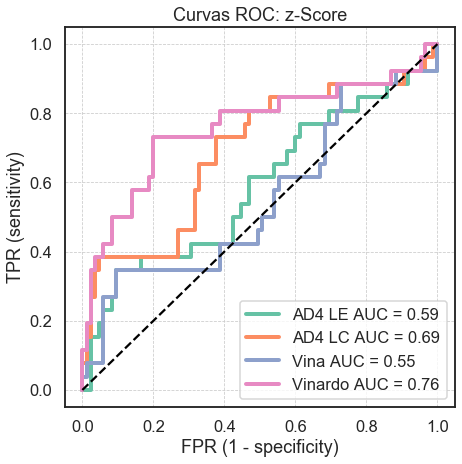

In [21]:
add_plot_roc(z_score_ad4_LE, true_values, "AD4 LE")
add_plot_roc(z_score_ad4_LC, true_values, "AD4 LC")
add_plot_roc(z_score_vina, true_values, "Vina")
plot_roc(z_score_vrd, true_values, "Vinardo", "Curvas ROC: z-Score")

## ROC con *ranking* de los scores de una sola conformación
Curva ROC a partir del *ranking* de una conformación dada: "**1aq1**"

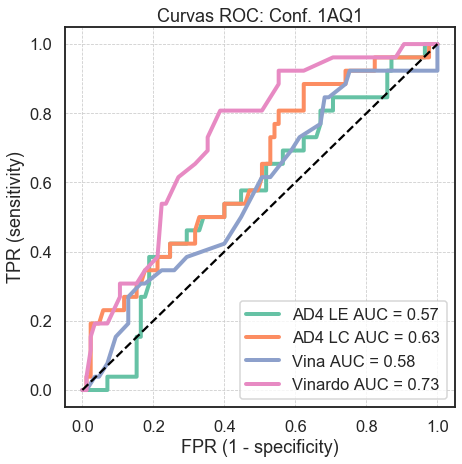

In [22]:
# Curva ROC dada una conformación
pdb_id = "1aq1"
add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo", F"Curvas ROC: Conf. {pdb_id.upper()}")

## Calculamos el AUC para todas las conformaciones
Se realiza el cálculo del AUC de todas las conformaciones tomando en cuenta los 4 DataFrames de *scores* disponibles.

In [16]:
# Calculo del AUC por conformaión
# carga del dataFrame con la información general de las estructuras cristalográficas
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")

**Cálculo de AUC para cada conformación.**

In [17]:
df_cdk2_labels["AUC_vrd_16x"] = 0.0
df_cdk2_labels["AUC_vina_16x"] = 0.0
df_cdk2_labels["AUC_ad4_LC"] = 0.0
for pdb in df_cdk2_labels.index:
    # Vinardo 16x
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd_16x"] = roc_vrd
    # Vina 16x
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vina_16x"] = roc_vina
    # Autodock 4: LE
    roc_ad4_LE = roc_auc_score(np.array(true_values), - df_ad4_results_LE[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LE"] = roc_ad4_LE
    # Autodock 4: LC
    roc_ad4_LC = roc_auc_score(np.array(true_values), - df_ad4_results_LC[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LC"] = roc_ad4_LC

### Guardamos el dataFrame

<div class="p-3 mb-2 bg-warning text-dark">Descomentar para guardar.</div>

In [25]:
# Guardamos el dataframe
# df_cdk2_labels.to_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")

## Conformaciones minimizadas

In [18]:
df_cdk2_labels["AUC_vrd_402MIN"] = 0.0
df_cdk2_labels["AUC_vina_402MIN"] = 0.0
for pdb in df_cdk2_labels.index:
    # Vinardo 16x, con conformaciones de proteína minimizadas
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results_MIN[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd_402MIN"] = roc_vrd
    # Vina 16x, con conformaciones de proteina minimizadas
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results_MIN[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vina_402MIN"] = roc_vina

## Tabla Final

In [22]:
df_cdk2_labels.iloc[:, -8:]

Inhib_mass Labels_conf  AUC_vrd_16x  AUC_vina_16x  AUC_ad4_LC  \
1aq1      440.0     inact_b     0.730317      0.575339    0.634163   
1b38      398.0     inact_a     0.677828      0.546154    0.571946   
1b39      398.0     inact_a     0.764706      0.580543    0.670814   
1buh                inact_a     0.708145      0.535294    0.613348   
1ckp      214.0     inact_a     0.766968      0.571493    0.764932   
...         ...         ...          ...           ...         ...   
6q4g      258.0     inact_a     0.629638      0.547511    0.539593   
6q4h      274.0     inact_a     0.534389      0.467873    0.496606   
6q4i      234.0     inact_a     0.644118      0.559276    0.580769   
6q4j      218.0     inact_a     0.557692      0.502262    0.538235   
6q4k                inact_a     0.651584      0.518326    0.506561   

      AUC_ad4_LE  AUC_vrd_402MIN  AUC_vina_402MIN  
1aq1    0.572172        0.726471         0.565385  
1b38    0.483032        0.656109         0.535520  
1b39    0.607919        0.668326         0.483258  
1buh    0.544344        0.781900         0.638009  
1ckp    0.715385        0.709276         0.546833  
...          ...             ...              ...  
6q4g    0.483484        0.585747         0.508597  
6q4h    0.467195        0.538914         0.480543  
6q4i    0.486652        0.616063         0.516063  
6q4j    0.478733        0.516968         0.525113  
6q4k    0.428733        0.653167         0.506561  

[402 rows x 8 columns]

## Conformaciones con mejor AUC por Método de score
### ROC con *ranking* de la MEJOR conformación en Vinardo a 16x
Curva ROC a partir del *ranking* de la mejor conformación con Vinardo (conformación con mejor AUC de vinardo).

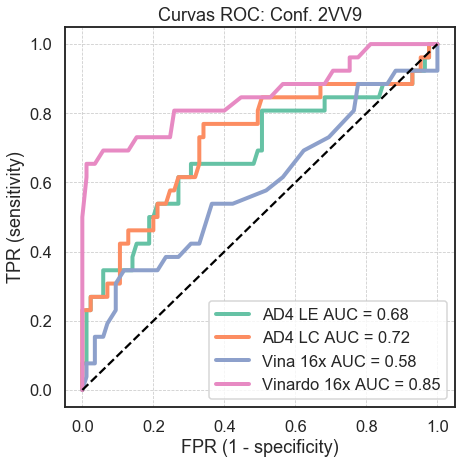

In [26]:
# ROC de la mejor conformación de vinardo
pdb_id = df_cdk2_labels[["AUC_vrd_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con *ranking* de la MEJOR conformación en Vinardo a 8x

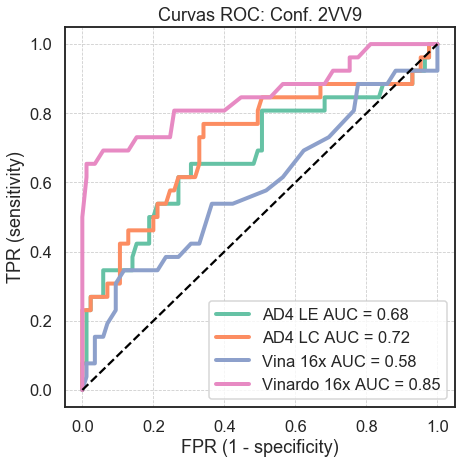

In [27]:
# ROC de la mejor conformación de vinardo a 8x
pdb_id = df_cdk2_labels[["AUC_vrd_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en Vina a 16x

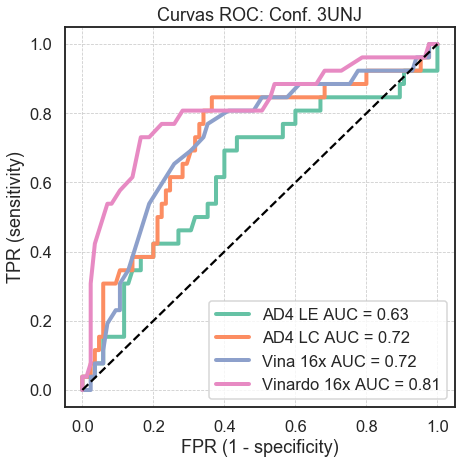

In [28]:
# ROC de la mejor conformación de vina a 16x
pdb_id = df_cdk2_labels[["AUC_vina_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en AD4 LC

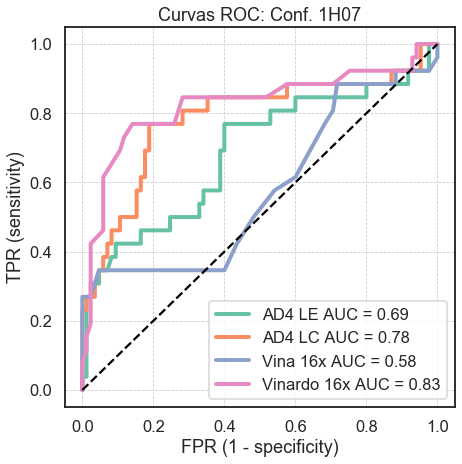

In [29]:
# ROC de la mejor conformación de ad4 LC
pdb_id = df_cdk2_labels[["AUC_ad4_LC"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en AD4 LE

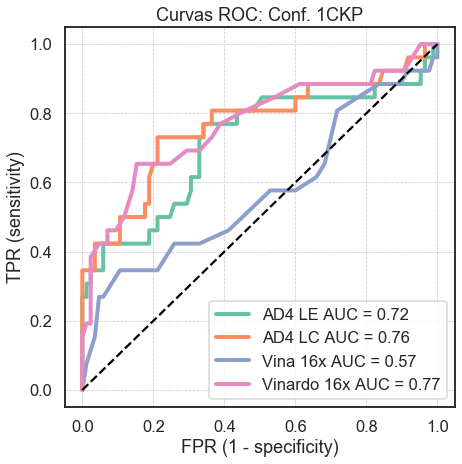

In [30]:
# ROC de la mejor conformación de ad4 LC
pdb_id = df_cdk2_labels[["AUC_ad4_LE"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

## Distribución de AUC por programa de *docking*
### *Violin plots*

In [31]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                'AUC_vina_16x', 'AUC_vrd_16x']]

## Valor de AUC por scoring vs conformación
**Se comparar únicamente los resultados en la evaluación con el set de CSAR**

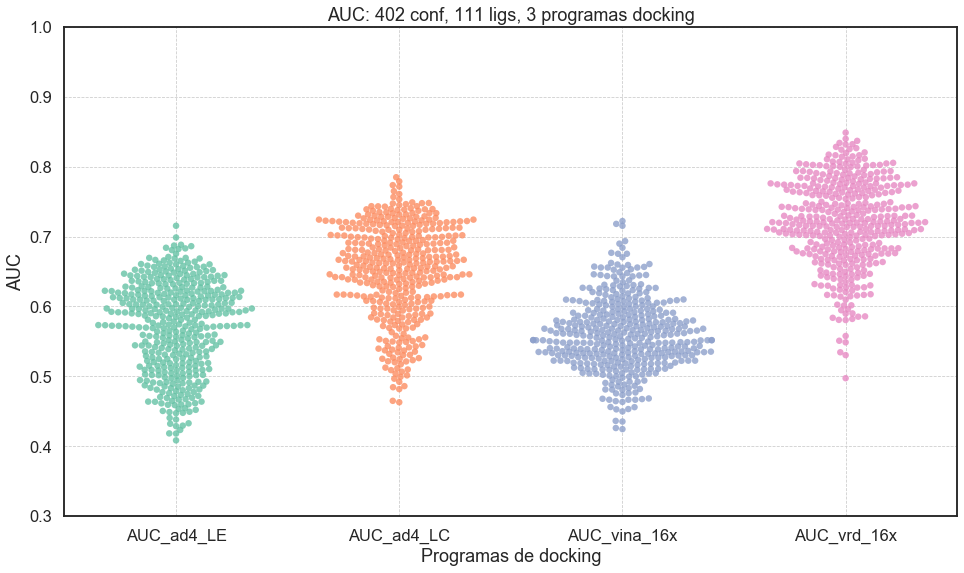

In [32]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fa9a58',  '#cf384d', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
               palette=  'Set2', s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

## Comparación con conformaciones minimizadas
### Vina y Vinardo

In [23]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores_CRYS_vs_MIN = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                                            'AUC_vina_16x', 'AUC_vrd_16x',
                                            'AUC_vina_402MIN', 'AUC_vrd_402MIN']]

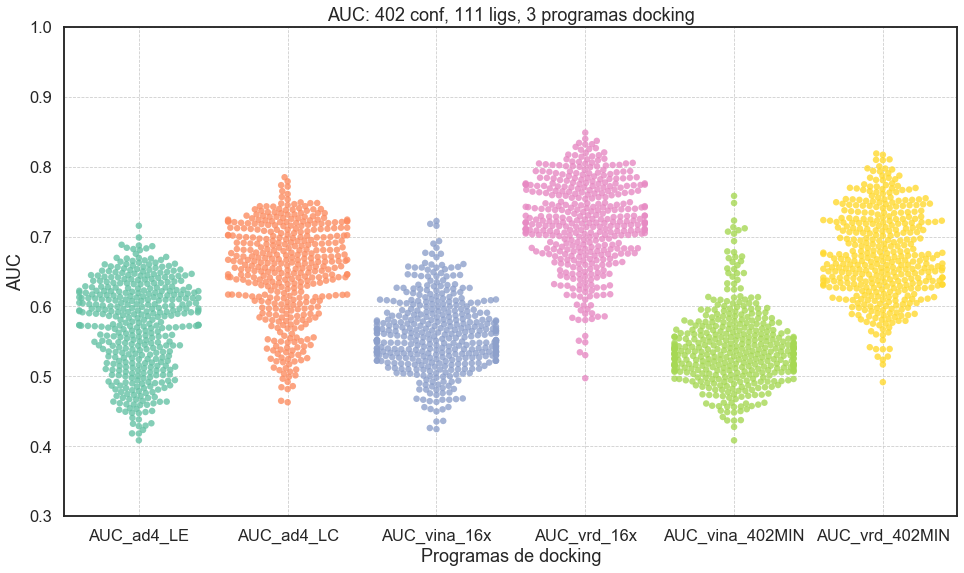

In [25]:
fig, axes = plt.subplots()

data = df_auc_scores_CRYS_vs_MIN
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 6)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
               palette=  'Set2', s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

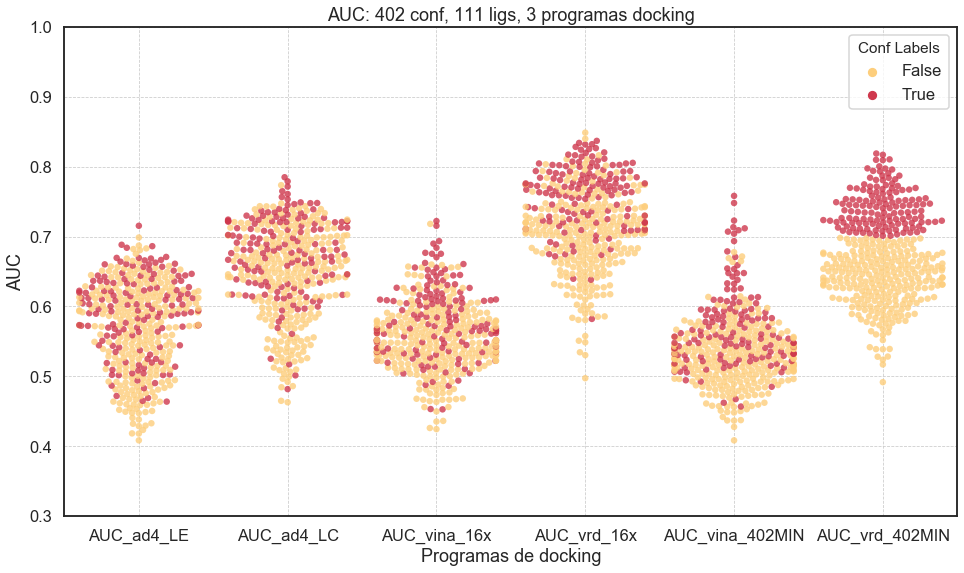

In [33]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores_CRYS_vs_MIN
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.AUC_vrd_402MIN > 0.7, 6)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Mejores conformaciones de Vinardo (AUC de >0.8)

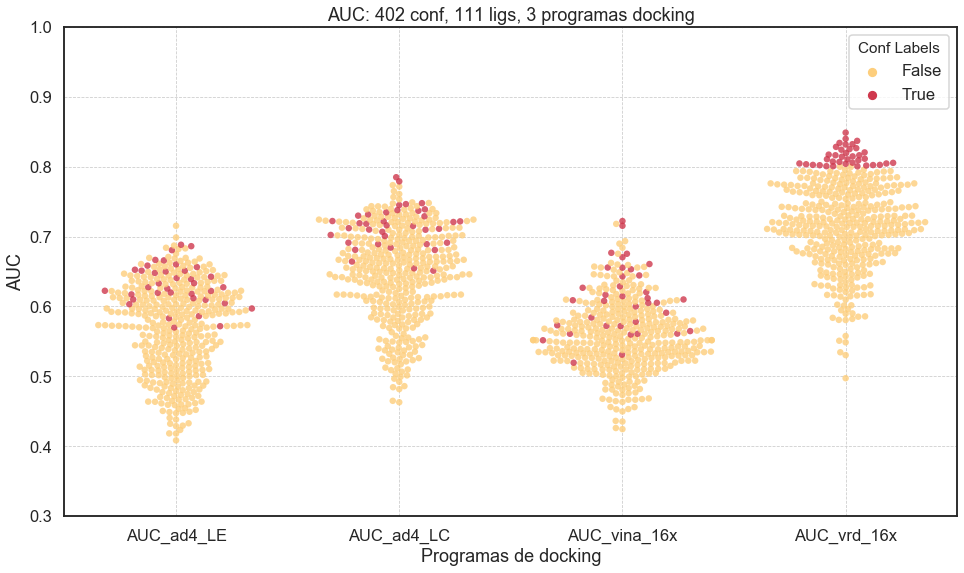

In [33]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.AUC_vrd_16x > 0.8, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Etiquetado de las conforamciones según su estado Activo/Inactivo

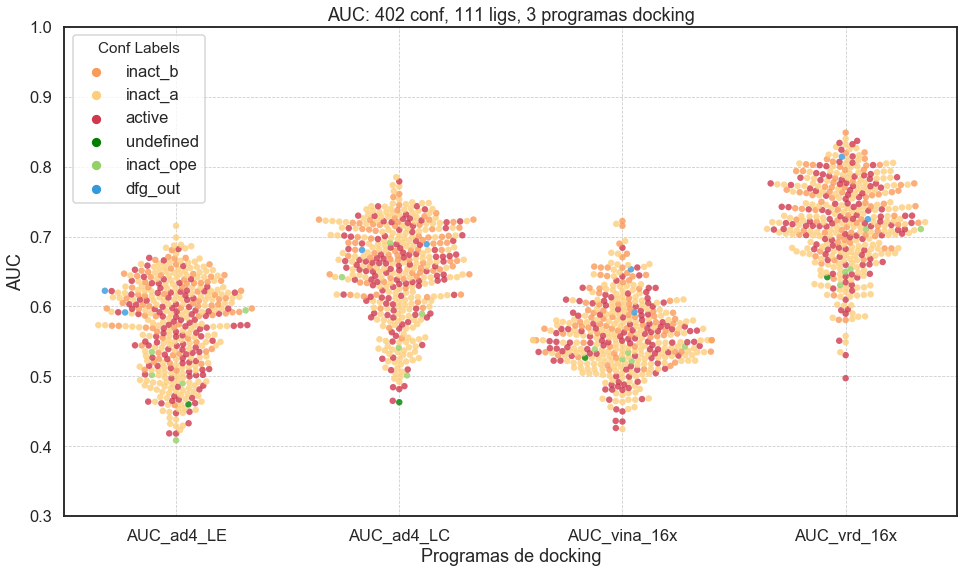

In [34]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fa9a58', '#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

## Comparación por otras propidades de las conformaciones
### Conformaciones según la resolución del cristal

In [35]:
df_cdk2_labels.Resolution.describe()

count    402.000000
mean       2.023657
std        0.408628
min        0.980000
25%        1.800000
50%        1.990000
75%        2.247500
max        3.500000
Name: Resolution, dtype: float64

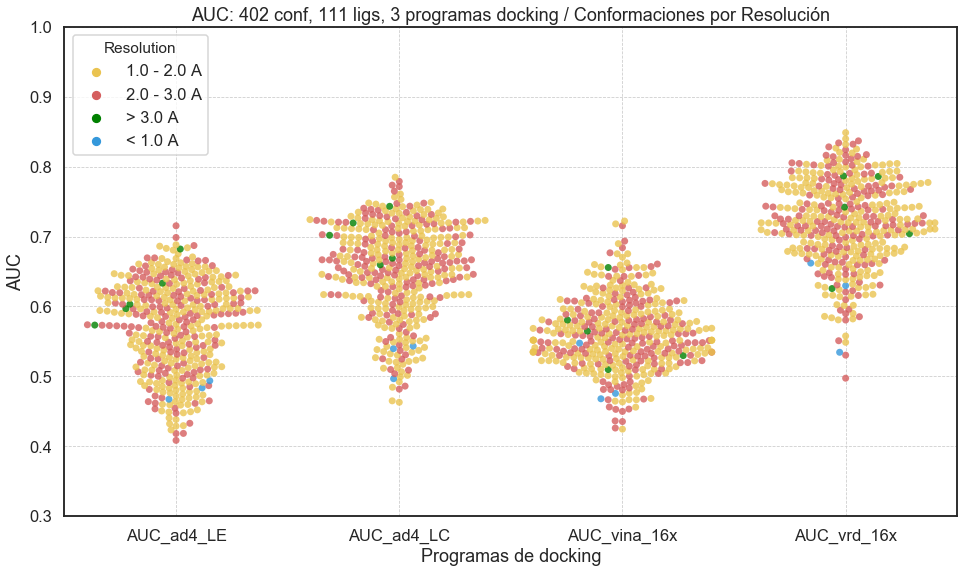

In [36]:
# Por  resoluciones de las conformaciones
resolution = ["< 1.0 A" if i <= 1.0
              else "1.0 - 2.0 A" if i <= 2
              else "2.0 - 3.0 A" if i <= 3
              else "> 3.0 A"
              for i in df_cdk2_labels.Resolution]

fig, axes = plt.subplots()

cmp = sns.set_palette(['#EAC350',  '#D55E5E', 'green',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Resolution'] = np.tile(resolution, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Resolution", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Resolución')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Por cobertura de secuencia en la estructura cristalográfica

In [37]:
df_cdk2_labels.Coverage.describe()

count    402.000000
mean      97.065011
std        2.788320
min       86.577181
25%       94.966443
50%       97.986577
75%       99.328859
max      102.013423
Name: Coverage, dtype: float64

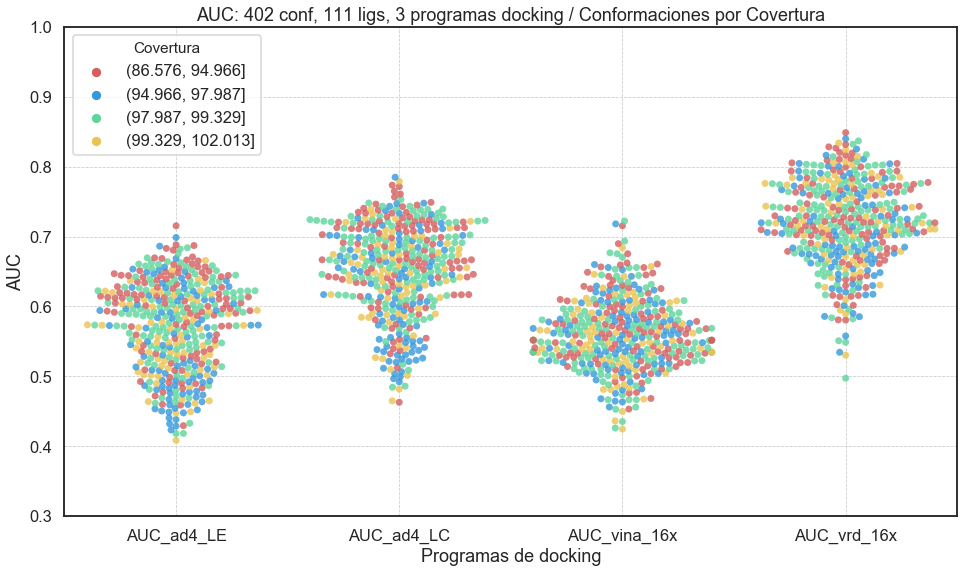

In [38]:
# por covertura de las Conformaciones
# Por  resoluciones de las conformaciones
covertura = pd.qcut(df_cdk2_labels.Coverage, 4)


fig, axes = plt.subplots()

cmp = sns.set_palette(['#D55E5E', '#3498db',  '#5ED59B', '#EAC350'])
data = df_auc_scores
data = data.melt()
data['Covertura'] = np.tile(covertura, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Covertura", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Covertura')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Por volumen de la cavidad

In [39]:
# Cargamos los valores del volumen del pocket
col_names = ['frame', 'pocket_volume']
volumen_402_stc = pd.read_csv('../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_RICCI_402/res_volumes.tabbed.txt', 
                              sep = "\t", header=None, names= col_names)

In [40]:
volumen_402_stc[['pocket_volume']].describe()

pocket_volume
count     402.000000
mean      779.631841
std       138.063446
min       405.000000
25%       684.250000
50%       760.000000
75%       843.750000
max      1534.000000

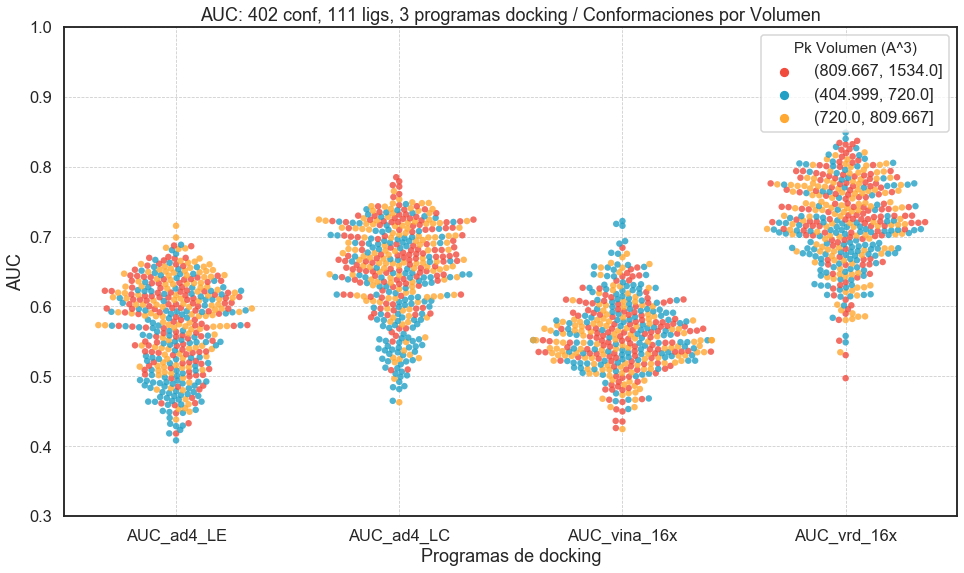

In [41]:
volumen = pd.qcut(volumen_402_stc.pocket_volume, 3)

fig, axes = plt.subplots()

cmp = sns.set_palette(['#F14B3E', '#21A0C5', '#FFA832'])
data = df_auc_scores
data = data.melt()
data['Pk Volumen (A^3)'] = np.tile(volumen, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = 'Pk Volumen (A^3)', palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Volumen')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Conformaciones por cluster según su cavidad
**Propiedad medida con POVME**

In [42]:
# por cluster de pocket
cluster_members_file = '../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_PISANI_402/res_frameInfo/cluster_members.csv'
with open(cluster_members_file) as f:
    lines = f.readlines()

dic_cluster_pockets = {}
for i, line in enumerate(lines):
    split_line = line.replace('\n', '').split(' ')
    dic_cluster_pockets[F'cluster_{i+1}'] = ([ int(element.split('__')[-1]) -1 for element in split_line])
    
df_cdk2_labels['pocket_cluster'] = 0
# Llenamos la columna
df_cdk2_labels.reset_index(inplace=True)
for key in dic_cluster_pockets.keys():
    for value in dic_cluster_pockets[key]:
        df_cdk2_labels.at[value, 'pocket_cluster'] = int(key.split('_')[-1])

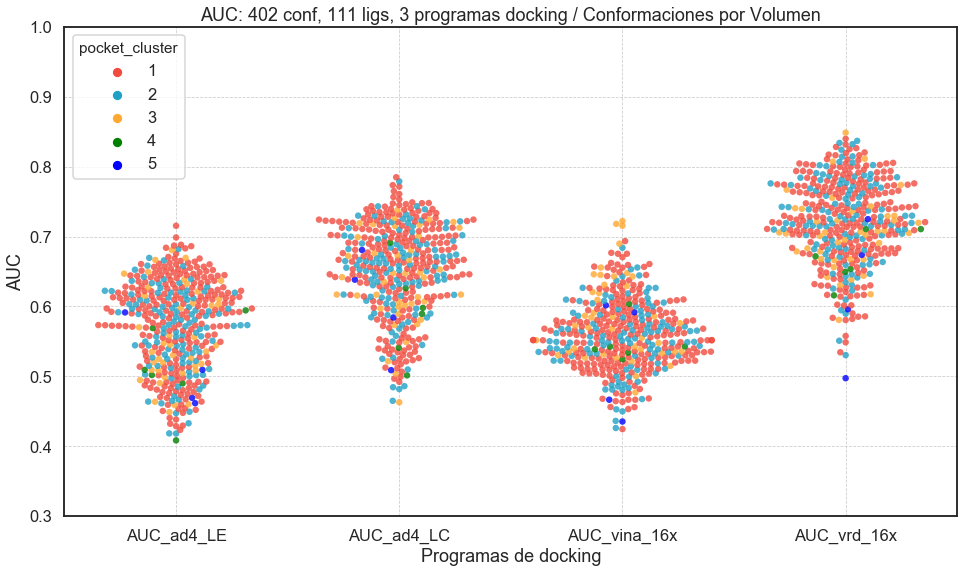

In [43]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#F14B3E', '#21A0C5', '#FFA832', 'green', 'blue'])
data = df_auc_scores
data = data.melt()
data['pocket_cluster'] = np.tile(df_cdk2_labels['pocket_cluster'], 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = 'pocket_cluster', palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Volumen')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Conformaciones por masa del ligando
**Conformaciones según la masa del ligando acoplado en el sitio activo, conforamciones sin ligando la masa = 0.**

In [44]:
df_cdk2_labels.Inhib_mass.replace("", 0, inplace=True)
pd.to_numeric(df_cdk2_labels.Inhib_mass).describe()

count    402.000000
mean     285.216418
std      115.075581
min        0.000000
25%      238.000000
50%      306.000000
75%      366.000000
max      462.000000
Name: Inhib_mass, dtype: float64

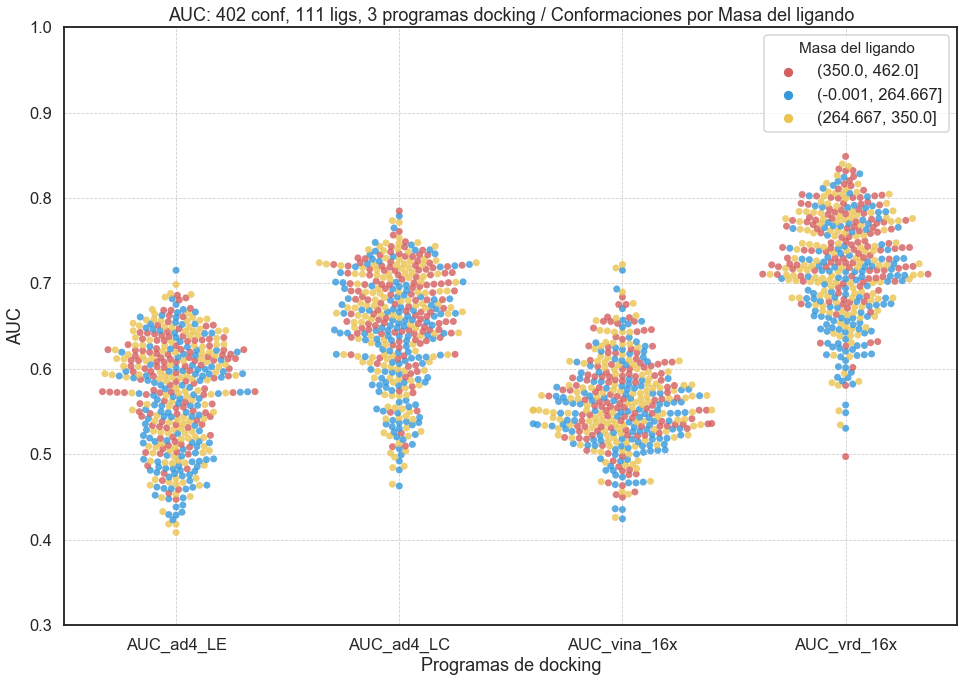

In [45]:
masa_ligando = pd.qcut(pd.to_numeric(df_cdk2_labels.Inhib_mass), 3)

fig, axes = plt.subplots()

cmp = sns.set_palette(['#D55E5E', '#3498db', '#EAC350'])
data = df_auc_scores
data = data.melt()
data['Masa del ligando'] = np.tile(masa_ligando, 4)

fig.set_size_inches(16, 11)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Masa del ligando", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Masa del ligando')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

# Análisis estadístico 
### Análisis estadístico  de la distribución de valores AUC por método de docking

In [46]:
# Evaluamos la normalidad de los datos
import pylab
import scipy.stats as stats
import statsmodels.api as sm

In [47]:
df_auc_scores.describe().T

count      mean       std       min       25%       50%  \
AUC_ad4_LE    402.0  0.571919  0.064531  0.408371  0.522002  0.583484   
AUC_ad4_LC    402.0  0.651196  0.066604  0.462896  0.611595  0.661538   
AUC_vina_16x  402.0  0.560658  0.051570  0.424434  0.527376  0.557240   
AUC_vrd_16x   402.0  0.719259  0.061990  0.497285  0.680769  0.720814   

                   75%       max  
AUC_ad4_LE    0.621719  0.715385  
AUC_ad4_LC    0.702149  0.784842  
AUC_vina_16x  0.591968  0.722172  
AUC_vrd_16x   0.768269  0.848643

## Normalidad de los datos

La prueba de hipótesis para cada muestra $i$ es la siguiente:

> $H_0$: *La muestra $i$ sigue una distribución normal.* 

> $H_a$: *La muestra $i$ __NO__ sigue una distribución normal.* 

#### *Test* de Shapiro-Wilks con datos crudos

In [48]:
# Normalidad de los datos
for test in df_auc_scores.columns:
    norm_t = stats.shapiro(df_auc_scores[test])
    print(F'{test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

AUC_ad4_LE:	 W = 0.973  p = 0.0
AUC_ad4_LC:	 W = 0.965  p = 0.0
AUC_vina_16x:	 W = 0.993  p = 0.04831
AUC_vrd_16x:	 W = 0.982  p = 6e-05


#### *Test* de Shapiro-Wilks con datos estandarizados

In [49]:
from sklearn.preprocessing import StandardScaler
# Datos estandarizados (z-score)
df_std_auc_values = pd.DataFrame(StandardScaler().fit_transform(df_auc_scores), 
                                 columns= df_auc_scores.columns)

In [50]:
# Normalidad de los datos estandarizados
for test in df_std_auc_values.columns:
    norm_t = stats.shapiro( df_std_auc_values[test])
    print(F'stdrzd {test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

stdrzd AUC_ad4_LE:	 W = 0.973  p = 0.0
stdrzd AUC_ad4_LC:	 W = 0.965  p = 0.0
stdrzd AUC_vina_16x:	 W = 0.993  p = 0.04832
stdrzd AUC_vrd_16x:	 W = 0.982  p = 6e-05


#### *Test* de Shapiro-Wilks con transformación logarítmica

In [51]:
# Transformación de los datos, logaritmo base 10
df_log_auc_values = np.log10(df_auc_scores)
for test in df_log_auc_values.columns:
    norm_t = stats.shapiro( df_log_auc_values[test])
    print(F'log_{test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

log_AUC_ad4_LE:	 W = 0.959  p = 0.0
log_AUC_ad4_LC:	 W = 0.945  p = 0.0
log_AUC_vina_16x:	 W = 0.996  p = 0.43003
log_AUC_vrd_16x:	 W = 0.965  p = 0.0


**En cualquiera de los tres caso casos, para todas las muestras, se obtiene `p-value < 0.05`, con lo cual se rechaza la hipótesis nula y se concluye, con un nivel de significancia del 95\%, que ninguana de las muestras sigue una distribución normal.**

###  Q-Q plots
Sólo para visualizar la distribución de los datos.

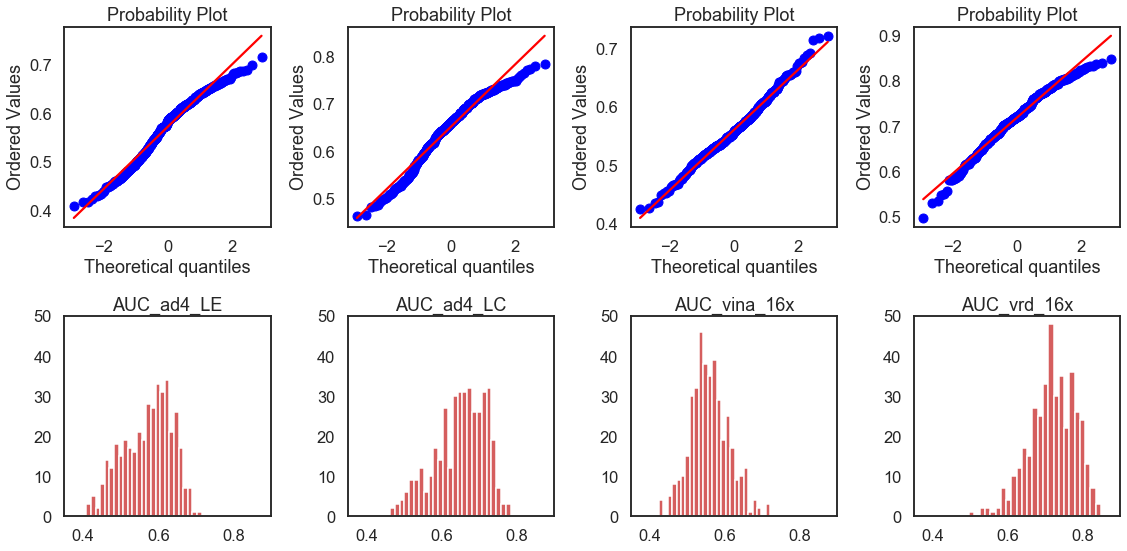

In [52]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 8)

for i, auc_results in enumerate(df_auc_scores.columns):
    plt.subplot(2, 4, i + 1)
    stats.probplot(df_auc_scores[auc_results], dist = "norm", plot=pylab)
    plt.subplot(2, 4, i + 5)
    plt.hist(df_auc_scores[auc_results], bins= 25)
    plt.xlim((0.35, 0.9))
    plt.ylim((0, 50))
    plt.title(auc_results)
fig.tight_layout()  
plt.show()

# Evaluación de la Homocedasticidad
La prueba de hipótesis es la siguiente:
> $H_0$: *Todas las muestras son homocedasticas.* $\Longrightarrow \sigma_0 = \sigma_1 ... = \sigma_k$

> $H_0$: *Al menos un par de muestras tienen varianzas distintas.* $\Longrightarrow \sigma_i \neq \sigma_j$ 

### *Test de Levenne* para muestras no normales
#### Datos crudos

In [53]:
# Test de levene para evaluar homocedasticidad en muestras no normales
stats.levene(*df_auc_scores.T.values,  center="median")

LeveneResult(statistic=11.01377348278758, pvalue=3.6973467468158526e-07)

> **Conclusión:** Cuando los **datos crudos** son evaluados, se rechaza la hipótesis nula y se cncluye que las muestras no son homocedásticas.

#### Datos estandarizados por columna (método de *docking*)

In [54]:
stats.levene(*df_std_auc_values.T.values,  center="median")

LeveneResult(statistic=0.4491018357286637, pvalue=0.717966164490951)

> **Conclusión:** Cuando los **datos estandarizados por método** son evaluados, se rechaza la hipótesis nula y se cncluye que las muestras no son homocedásticas.

### Visualización de la distribución de los datos

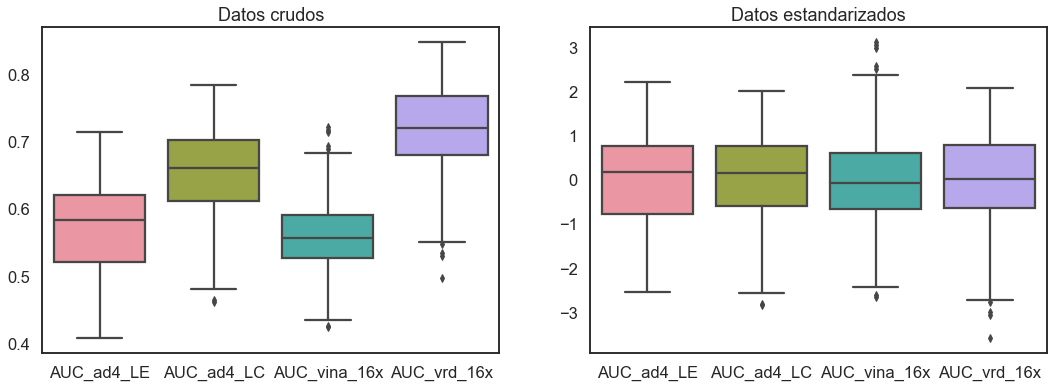

In [55]:
fig, axes = plt.subplots()
fig.set_size_inches(18, 6)

plt.subplot(1, 2, 1)
sns.boxplot(data = df_auc_scores)
plt.title("Datos crudos")
plt.subplot(1, 2, 2)
sns.boxplot(data = df_std_auc_values)
plt.title("Datos estandarizados")
plt.show()

> ### NOTA: 
A mi entender, deberíamos evaluar las muestras con los datos no estandarizados y que la escala de todos los datos es la misma: valores AUC.

# Comparación de las muestras
## Prueba de Kruskal-Wallis

La prueba de Kruskal-Wallis (KW) es la alternativa no paramétrica a la prueba ANOVA de una vía. KW es un test que emplea rangos para contrastar la hipótesis de que tres o más muestras hayan sido obtenidas de la misma población. 

Supuestos de Kruskal-Wallis:
1. **Aleatoreidad de las muestras.**
2. **Independencia de las muestras.**
3. **Homogeneidad de varianzas (sólo si se busca inferir sobre las medianas de los grupos):**
> #### Este supuesto puede omitirse si la inferencia se hace sobre *dominancia estocástica*:  
1. *Some authors state unambiguously that there are no distributional assumptions, others that the homogeneity of variances assumption applies just as for parametric ANOVA. The confusion results from how you interpret a significant result.  If you wish to compare medians or means, then the Kruskal-Wallis test also assumes that observations in each group are identically and independently distributed apart from location. If you can accept inference in terms of dominance of one distribution over another, then there are indeed no distributional assumptions.*  
*The commonest misuse of Kruskal-Wallis is to accept a significant result as indicating a difference between means or medians, even when distributions are wildly different. Such results should only be interpreted in terms of dominance. When distributions are similar, medians should be reported rather than means since they (in the form of mean ranks) are what the test is actually comparing. In fact, box and whisker plots with median, interquartile range, outliers and extremes should be the minimum requirement for reporting results of a Kruskal-Wallis test.*  
**[Referencia 1](https://influentialpoints.com/Training/Kruskal-Wallis_ANOVA_use_and_misuse.htm)**.
2. *Heterogeneous variances will make interpretation of the result more complex*  
**[Referencia 2](https://influentialpoints.com/Training/kruskal-wallis_anova.htm)**.
3. *If the distributions differ in shape and/or variance, a significant KW test implies there is at least one group that is stochastically greater (lesser) than the others, but its mean (and median, and first quartile, and eighty-eighth percentile, etc.) is not necessarily higher (lower) than the other groups.*  
**[Referencia 3](https://stats.stackexchange.com/questions/278001/kruskal-wallis-test-assumption-testing-and-interpretation-of-the-results)**.

### Prueba de hipótesis
Prueba de hipótesis (interpretada en términos de dominancia y no de las medianas de las muestras. Esto significa que la hipótesis alternativa es que existe una probabilidad significativa de que al obtener un individuo de al menos una muestra $i$ su valor más grande que la de algún individuo de otra muestr $j$:

> **$H_0$: Todas las muestras provienen de la misma población.**  
    $H_0$: Para cada par de muestras $ij \rightarrow P(X_i > X_j = 0.5)$

> **$H_a$: Al menos una muestra proviene de una población con una distribución distinta.**  
$H_0$: Para al menos un par de muestras $ij \rightarrow P(X_i > X_j \neq 0.5)$

### Ejecución de la prueba ([Fuente](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/))

Realizamos el test de Kruskal-Wallis sobre los datos en crudo (sin estandarizar).

In [56]:
H, p = stats.kruskal(*df_auc_scores.T.values)
print(F'H = %.5f\np = %.5f' % (H, p))

H = 849.90758
p = 0.00000


> #### Conclusión (Usando datos sin estandarizar): 
Se rechaza la hipótesis nula y se concluye, con un *p-value* < 0.001 que al menos una de las muestras es distinta.

### Prueba post-hoc

In [57]:
import scikit_posthocs as posthoc

In [58]:
phoc_wilcoxon = posthoc.posthoc_wilcoxon(df_auc_scores.T.values)
phoc_wilcoxon.columns = df_auc_scores.columns
phoc_wilcoxon.index = df_auc_scores.columns
phoc_wilcoxon.round(5)

AUC_ad4_LE  AUC_ad4_LC  AUC_vina_16x  AUC_vrd_16x
AUC_ad4_LE       -1.0000         0.0        0.0004          0.0
AUC_ad4_LC        0.0000        -1.0        0.0000          0.0
AUC_vina_16x      0.0004         0.0       -1.0000          0.0
AUC_vrd_16x       0.0000         0.0        0.0000         -1.0

> #### Conclusión (Usando datos sin estandarizar): 
Todos los pares de muestras $ij$ son significativamente distintos entre sí.

## Prueba de Friedman

Alternativa no paramétrica para el ANOVA de una vía con mediciones repetidas (muestras pareadas). Es usada para evaluar si tres o más muestras son distintas. Por lo tanto, al contrario de Kruskal-Wallis, esta prueba no asume independencia de las muestras. **[Fuente](https://statistics.laerd.com/spss-tutorials/friedman-test-using-spss-statistics.php)**


Supuestos del test de Friedman:
> 1. **Las muestras provienen de un mismo grupo medido en tres o más ocasiones.**
2. **Aleatoriedad de las muestras. Cada muestra es una muestra alatoria de la población.**
3. **Los valores son continuos o al menos ordinales.**
4. **Las muestras NO necesitan seguir una distribución normal.**

Prueba de hipótesis:

> **$H_0$: Todas las muestras provienen de la misma población.**  
    $H_0$: Para cada par de muestras $ij \rightarrow P(X_i > X_j = 0.5)$

> **$H_a$: Al menos una muestra proviene de una población con una distribución distinta.**  
$H_0$: Para al menos un par de muestras $ij \rightarrow P(X_i > X_j \neq 0.5)$

### Ejecución de la prueba Friedman

In [59]:
f, p = stats.friedmanchisquare(*df_auc_scores.T.values)
print(F'F = %.5f\np = %.5f' % (H, p))

F = 849.90758
p = 0.00000


> #### Conclusión (Usando datos sin estandarizar): 
Se rechaza la hipótesis nula y se concluye, con un *p-value* < 0.001 que al menos una de las muestras es distinta.

### Prueba post-hoc (Friedman)

In [60]:
phoc_nemenyi = posthoc.posthoc_nemenyi_friedman(df_auc_scores.values)
phoc_nemenyi.columns = df_auc_scores.columns
phoc_nemenyi.index = df_auc_scores.columns
phoc_nemenyi.round(3)

AUC_ad4_LE  AUC_ad4_LC  AUC_vina_16x  AUC_vrd_16x
AUC_ad4_LE        -1.000       0.001         0.748        0.001
AUC_ad4_LC         0.001      -1.000         0.001        0.001
AUC_vina_16x       0.748       0.001        -1.000        0.001
AUC_vrd_16x        0.001       0.001         0.001       -1.000

> #### Conclusión (Usando datos sin estandarizar): 
Sólo el par `AUC_vina` y `AUC_ad4_LE` son similares, el resto de los pares de muestras son significativamente distintos.

# ¡Terminado!